<a href="https://colab.research.google.com/github/sehab1611251/Predicting-National-Happiness-Levels-Using-Machine-Learning./blob/main/Predicting_National_Happiness_Levels_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install necessary R packages
install.packages(c("glmnet", "corrplot", "caret", "nnet", "pROC", "e1071"), repos="http://cran.r-project.org")

# Load the libraries
library(tidyverse)
library(readxl)
library(caret)
library(nnet)
library(glmnet)
library(pROC)
library(e1071)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘ModelMetrics’, ‘plyr’, ‘recipes’, ‘reshape2’, ‘proxy’


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




**#################### Step 1: Dataset Processing ################**

In [6]:
happiness_data <- read_excel("/content/Data.xls") # Import data
head(happiness_data)

Country name year Life Ladder Log GDP per capita Social support
1 Afghanistan  2008 3.723590    7.350416           0.4506623     
2 Afghanistan  2009 4.401778    7.508646           0.5523084     
3 Afghanistan  2010 4.758381    7.613900           0.5390752     
4 Afghanistan  2011 3.831719    7.581259           0.5211036     
5 Afghanistan  2012 3.782938    7.660506           0.5206367     
6 Afghanistan  2013 3.572100    7.680333           0.4835519     
  Healthy life expectancy at birth Freedom to make life choices Generosity
1 50.5                             0.7181143                    0.16765246
2 50.8                             0.6788964                    0.19080880
3 51.1                             0.6001272                    0.12131605
4 51.4                             0.4959014                    0.16357149
5 51.7                             0.5309350                    0.23758759
6 52.0                             0.5779554                    0.06266622
  Perceptions of corruption Positive affect Negative affect
1 0.8816863                 0.4142970       0.2581955      
2 0.8500354                 0.4814214       0.2370924      
3 0.7067661                 0.5169067       0.2753238      
4 0.7311085                 0.4798347       0.2671747      
5 0.7756198                 0.6135128       0.2679191      
6 0.8232041                 0.5474170       0.2733281

In [7]:
# The column names have spaces, which might make them a bit cumbersome to work with.
# So, renaming the columns.
happiness_data <- happiness_data %>%
  rename(
    Country_name = `Country name`,
    Life_Ladder = `Life Ladder`,
    Log_GDP_per_capita = `Log GDP per capita`,
    Social_support = `Social support`,
    Healthy_life_expectancy = `Healthy life expectancy at birth`,
    Freedom_to_make_life_choices = `Freedom to make life choices`,
    Perceptions_of_corruption = `Perceptions of corruption`,
    Positive_affect = `Positive affect`,
    Negative_affect = `Negative affect`
  )

head(happiness_data)

Country_name year Life_Ladder Log_GDP_per_capita Social_support
1 Afghanistan  2008 3.723590    7.350416           0.4506623     
2 Afghanistan  2009 4.401778    7.508646           0.5523084     
3 Afghanistan  2010 4.758381    7.613900           0.5390752     
4 Afghanistan  2011 3.831719    7.581259           0.5211036     
5 Afghanistan  2012 3.782938    7.660506           0.5206367     
6 Afghanistan  2013 3.572100    7.680333           0.4835519     
  Healthy_life_expectancy Freedom_to_make_life_choices Generosity
1 50.5                    0.7181143                    0.16765246
2 50.8                    0.6788964                    0.19080880
3 51.1                    0.6001272                    0.12131605
4 51.4                    0.4959014                    0.16357149
5 51.7                    0.5309350                    0.23758759
6 52.0                    0.5779554                    0.06266622
  Perceptions_of_corruption Positive_affect Negative_affect
1 0.8816863                 0.4142970       0.2581955      
2 0.8500354                 0.4814214       0.2370924      
3 0.7067661                 0.5169067       0.2753238      
4 0.7311085                 0.4798347       0.2671747      
5 0.7756198                 0.6135128       0.2679191      
6 0.8232041                 0.5474170       0.2733281

In [8]:
# Get a summary of each column
summary(happiness_data)

 Country_name            year       Life_Ladder    Log_GDP_per_capita
 Length:2199        Min.   :2005   Min.   :1.281   Min.   : 5.527    
 Class :character   1st Qu.:2010   1st Qu.:4.647   1st Qu.: 8.500    
 Mode  :character   Median :2014   Median :5.432   Median : 9.499    
                    Mean   :2014   Mean   :5.479   Mean   : 9.390    
                    3rd Qu.:2018   3rd Qu.:6.309   3rd Qu.:10.373    
                    Max.   :2022   Max.   :8.019   Max.   :11.664    
                                                   NA's   :20        
 Social_support   Healthy_life_expectancy Freedom_to_make_life_choices
 Min.   :0.2282   Min.   : 6.72           Min.   :0.2575              
 1st Qu.:0.7466   1st Qu.:59.12           1st Qu.:0.6565              
 Median :0.8355   Median :65.05           Median :0.7698              
 Mean   :0.8107   Mean   :63.29           Mean   :0.7479              
 3rd Qu.:0.9048   3rd Qu.:68.50           3rd Qu.:0.8594              
 Max.   :0.987

In [9]:
# Check the data types of each column
str(happiness_data)

# Check the dimension
dim(happiness_data)

# Convert Year to Factor
happiness_data$year <- as.factor(happiness_data$year)

# Count missing values in each column
colSums(is.na(happiness_data))

# Remove rows with missing values in any column
happiness_data_cleaned <- na.omit(happiness_data)

# Check dimensions of the cleaned dataset
dim(happiness_data_cleaned)

tibble [2,199 × 11] (S3: tbl_df/tbl/data.frame)
 $ Country_name                : chr [1:2199] "Afghanistan" "Afghanistan" "Afghanistan" "Afghanistan" ...
 $ year                        : num [1:2199] 2008 2009 2010 2011 2012 ...
 $ Life_Ladder                 : num [1:2199] 3.72 4.4 4.76 3.83 3.78 ...
 $ Log_GDP_per_capita          : num [1:2199] 7.35 7.51 7.61 7.58 7.66 ...
 $ Social_support              : num [1:2199] 0.451 0.552 0.539 0.521 0.521 ...
 $ Healthy_life_expectancy     : num [1:2199] 50.5 50.8 51.1 51.4 51.7 ...
 $ Freedom_to_make_life_choices: num [1:2199] 0.718 0.679 0.6 0.496 0.531 ...
 $ Generosity                  : num [1:2199] 0.168 0.191 0.121 0.164 0.238 ...
 $ Perceptions_of_corruption   : num [1:2199] 0.882 0.85 0.707 0.731 0.776 ...
 $ Positive_affect             : num [1:2199] 0.414 0.481 0.517 0.48 0.614 ...
 $ Negative_affect             : num [1:2199] 0.258 0.237 0.275 0.267 0.268 ...


[1] 2199   11

Country_name                         year 
                           0                            0 
                 Life_Ladder           Log_GDP_per_capita 
                           0                           20 
              Social_support      Healthy_life_expectancy 
                          13                           54 
Freedom_to_make_life_choices                   Generosity 
                          33                           73 
   Perceptions_of_corruption              Positive_affect 
                         116                           24 
             Negative_affect 
                          16

[1] 1958   11

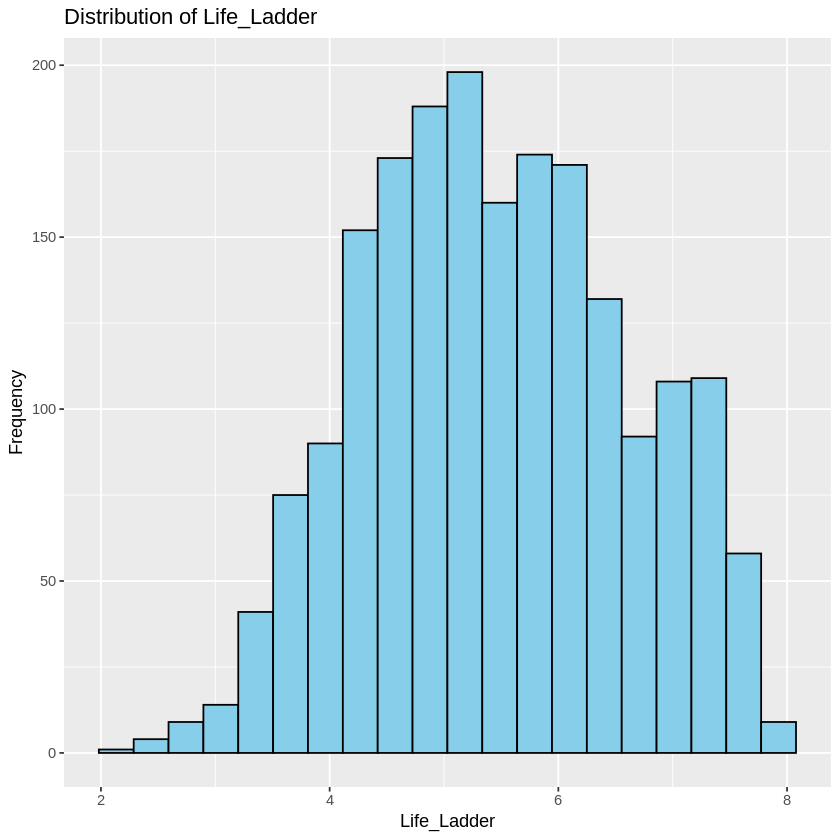

In [10]:
#.........Data Visualization..........#

# Histogram of Life_Ladder. To visualize the distribution of target variable.
ggplot(happiness_data_cleaned, aes(x = Life_Ladder)) +
  geom_histogram(bins = 20, fill = "skyblue", color = "black") +
  labs(title = "Distribution of Life_Ladder", x = "Life_Ladder", y = "Frequency")

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


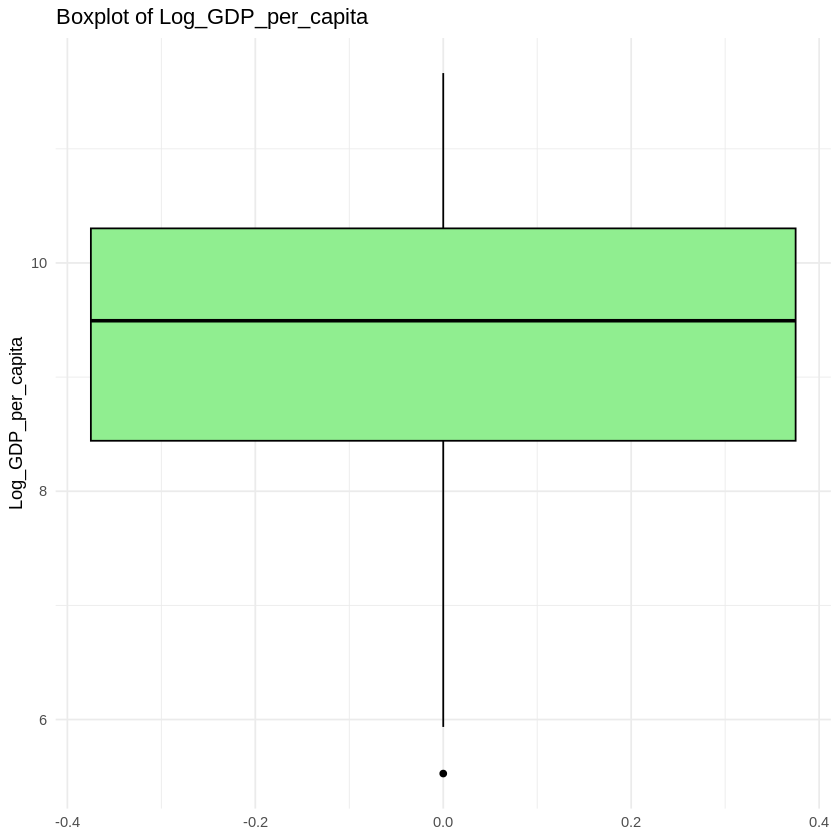

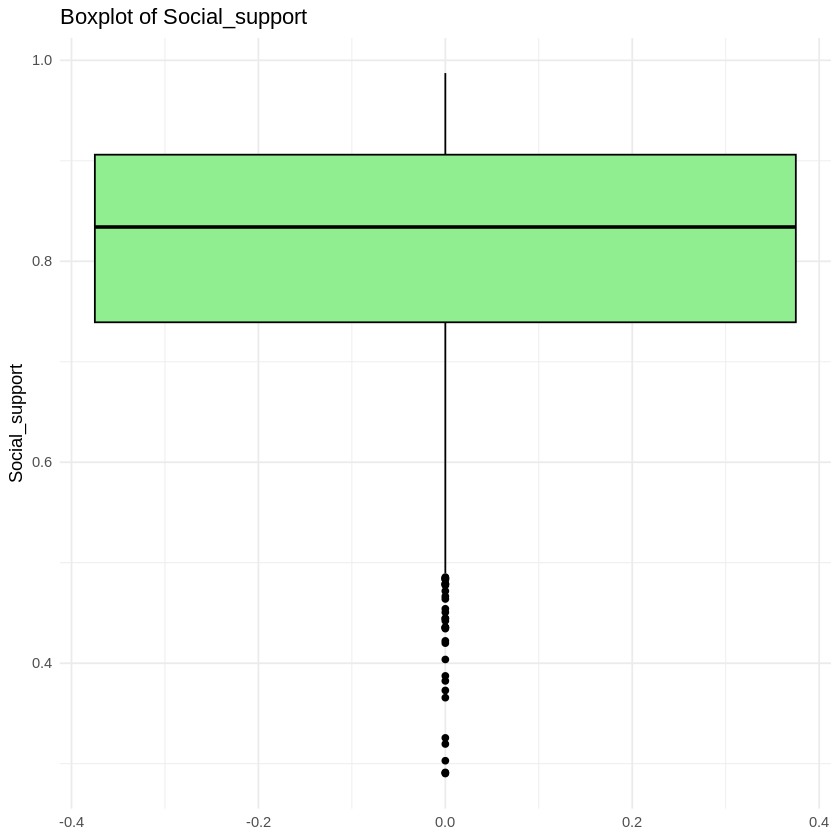

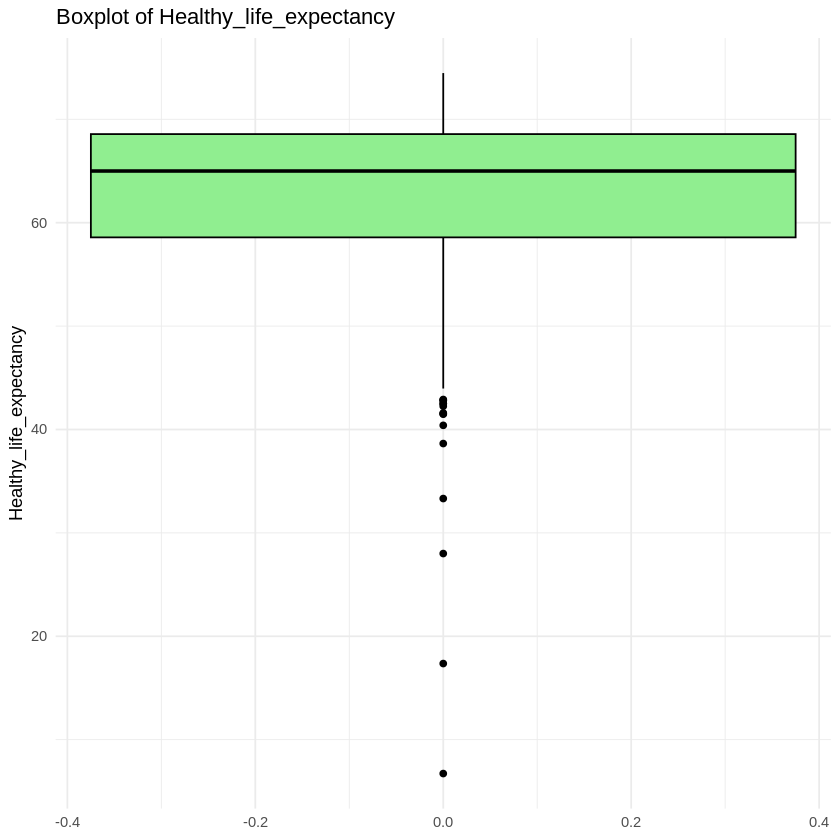

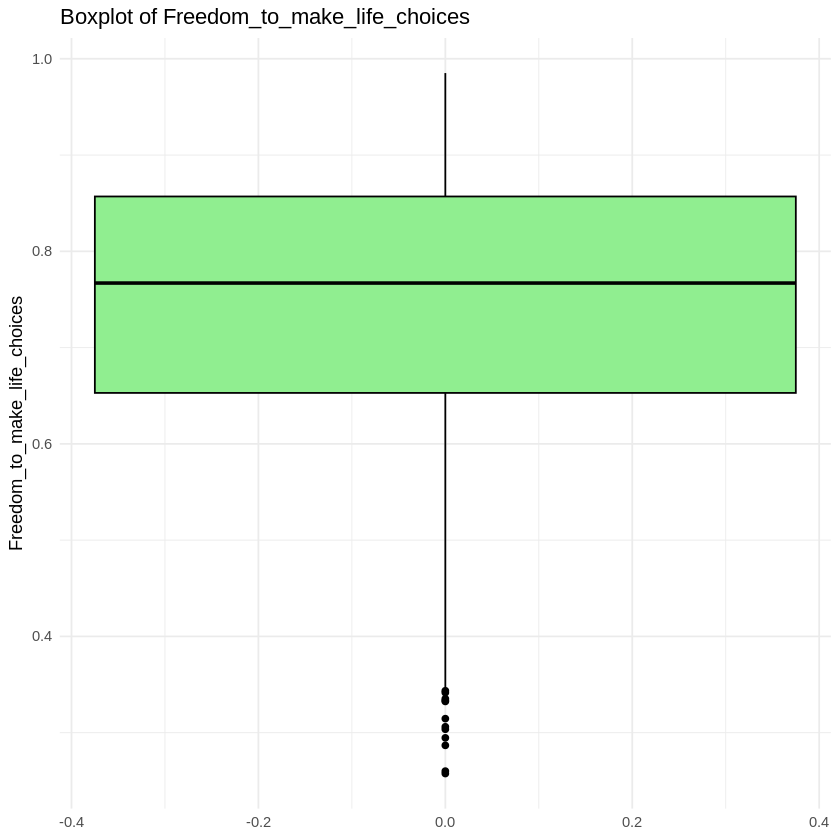

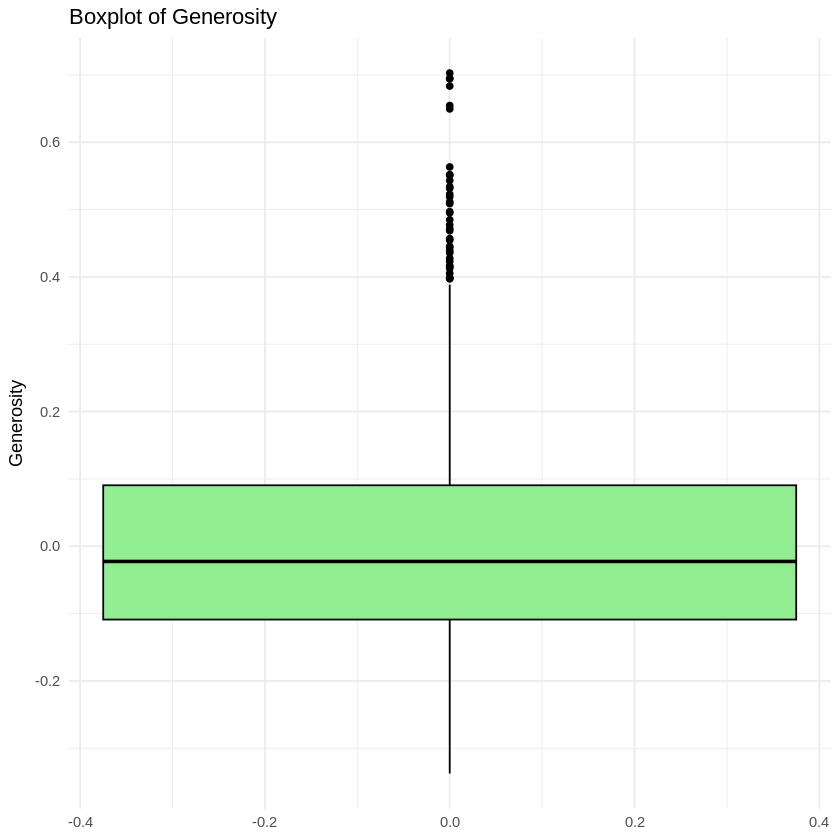

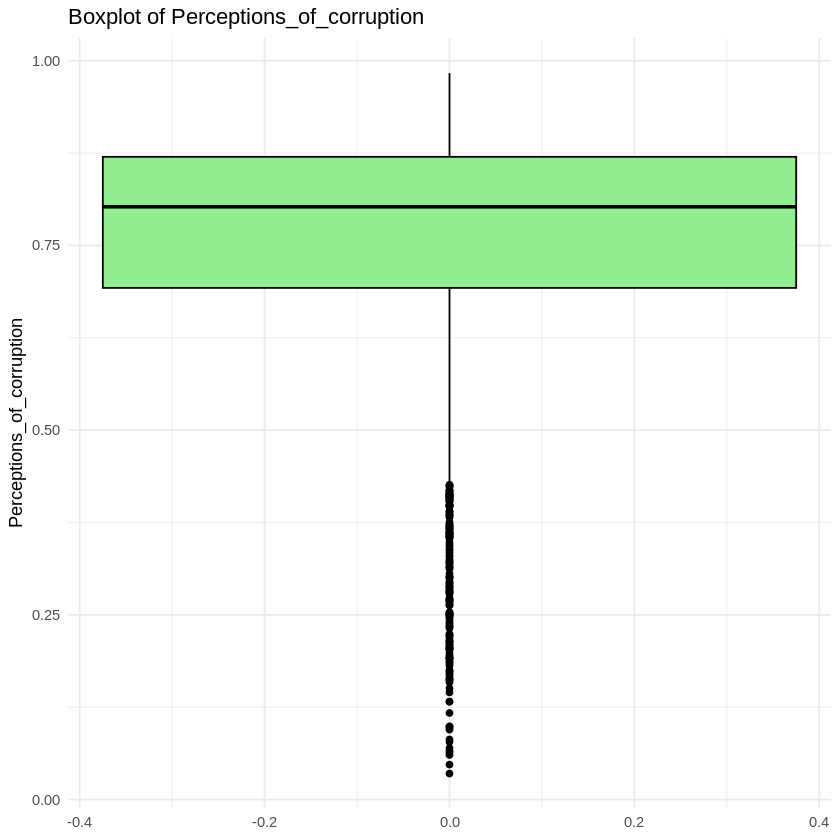

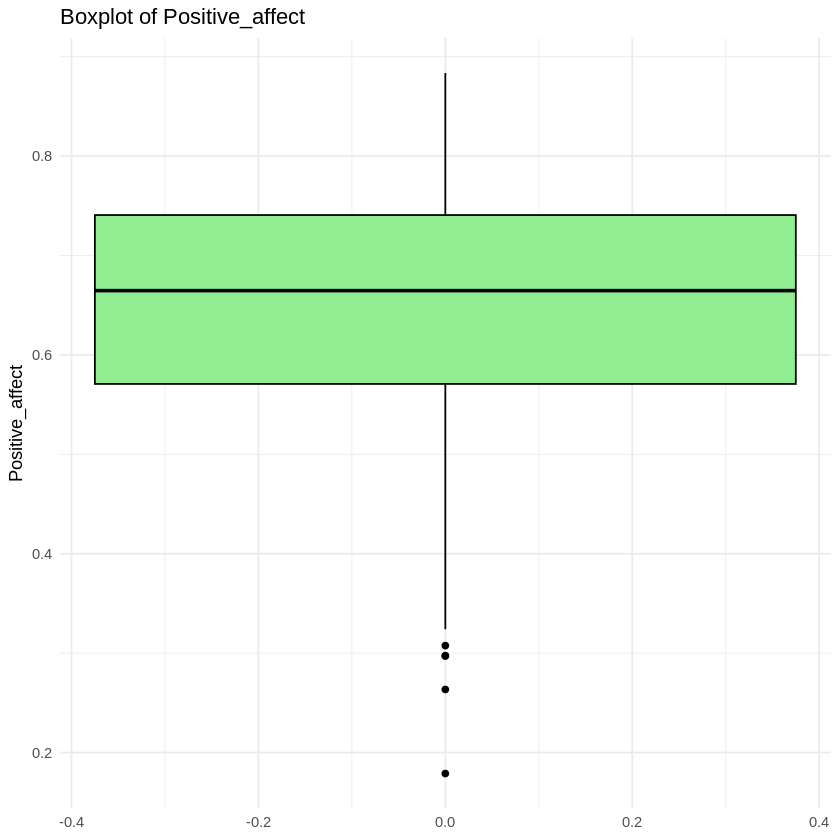

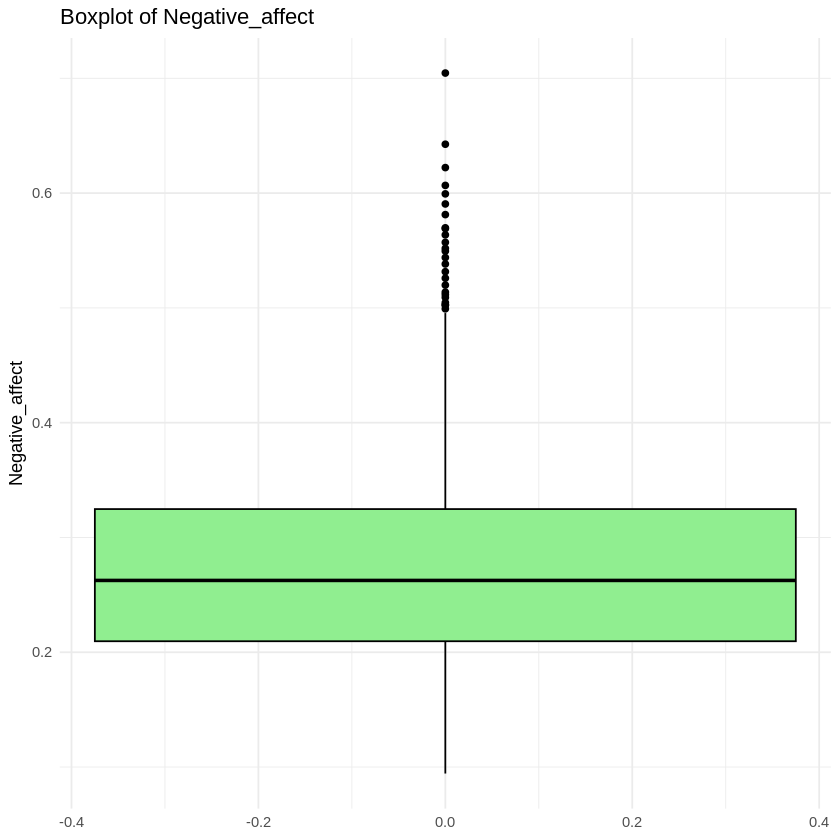

In [11]:
# Boxplots for All Predictors. To identify outliers in each predictor variable.
predictors <- c("Log_GDP_per_capita", "Social_support", "Healthy_life_expectancy",
                "Freedom_to_make_life_choices", "Generosity",
                "Perceptions_of_corruption", "Positive_affect", "Negative_affect")
for (predictor in predictors) {
  plot <- ggplot(happiness_data_cleaned, aes_string(y = predictor)) +
    geom_boxplot(fill = "lightgreen", color = "black") +
    labs(title = paste("Boxplot of", predictor), y = predictor) +
    theme_minimal()
  print(plot)
}

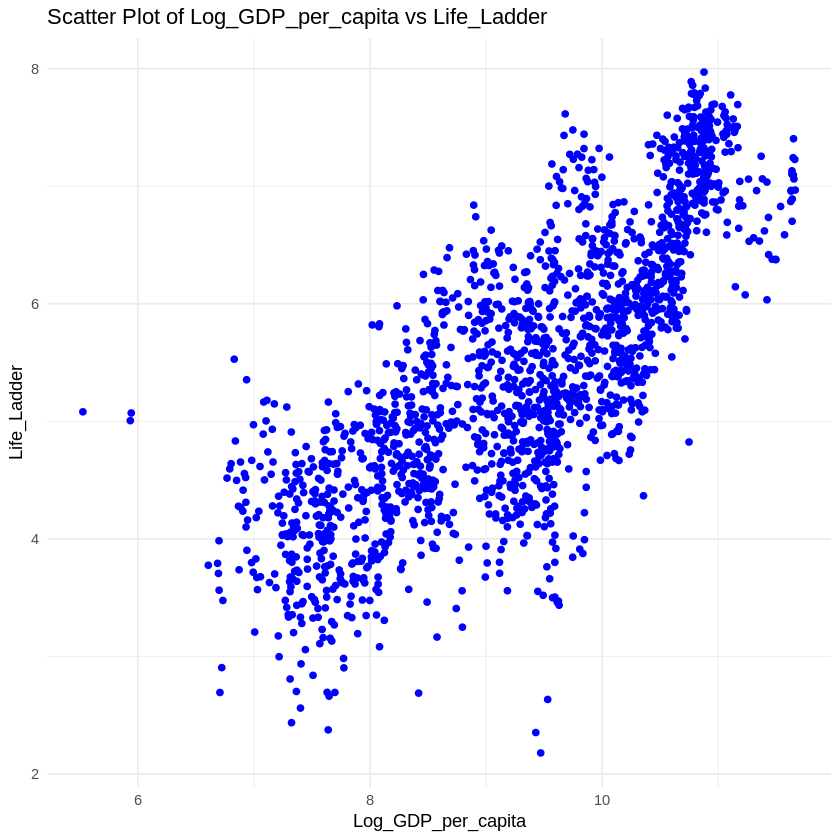

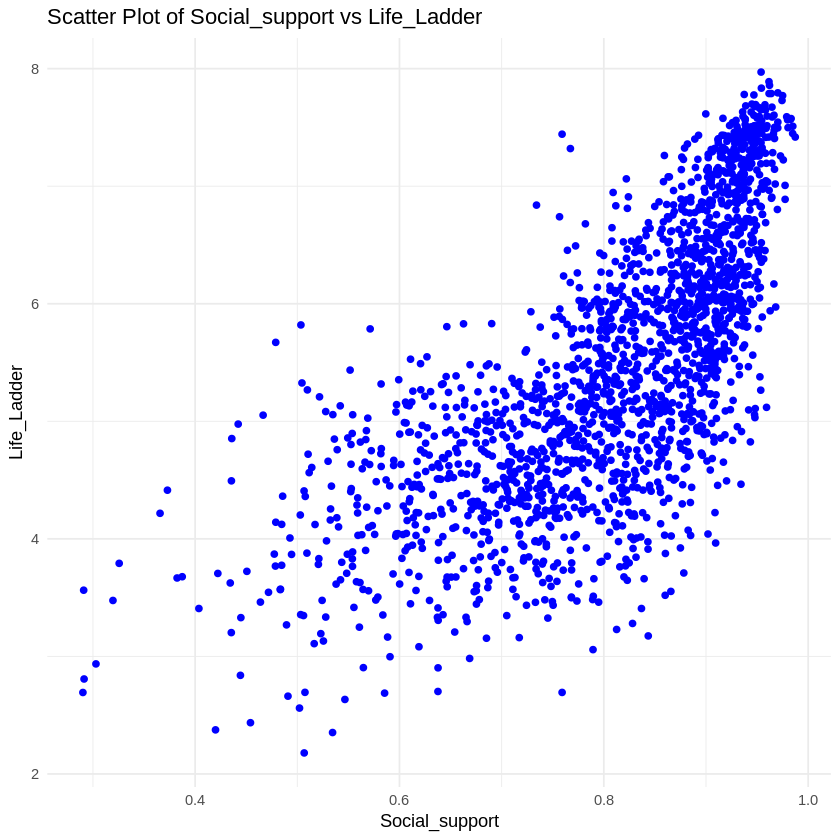

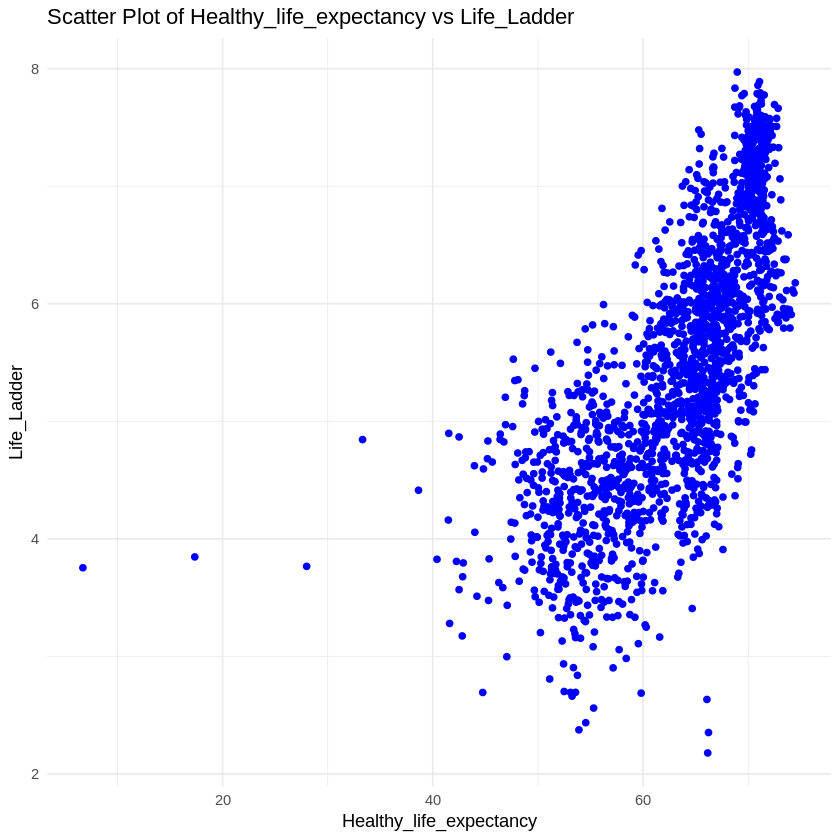

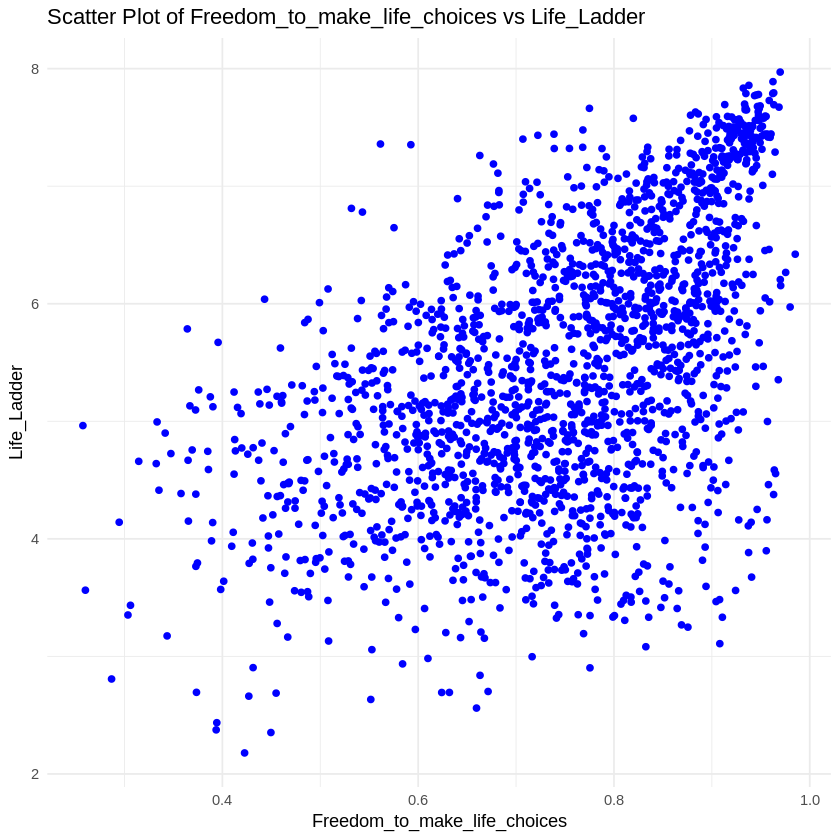

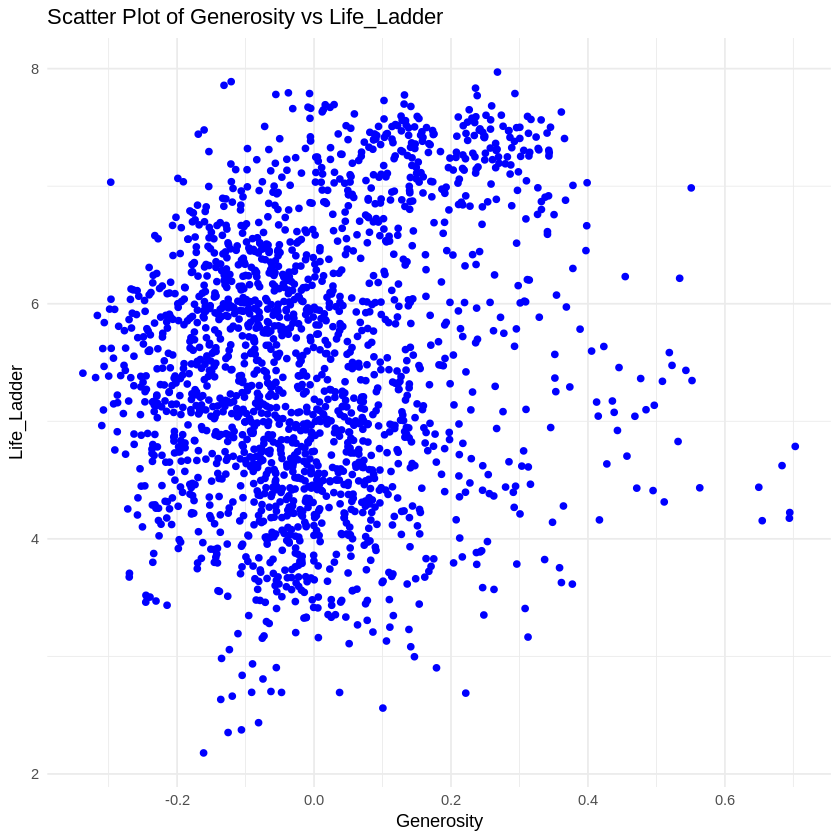

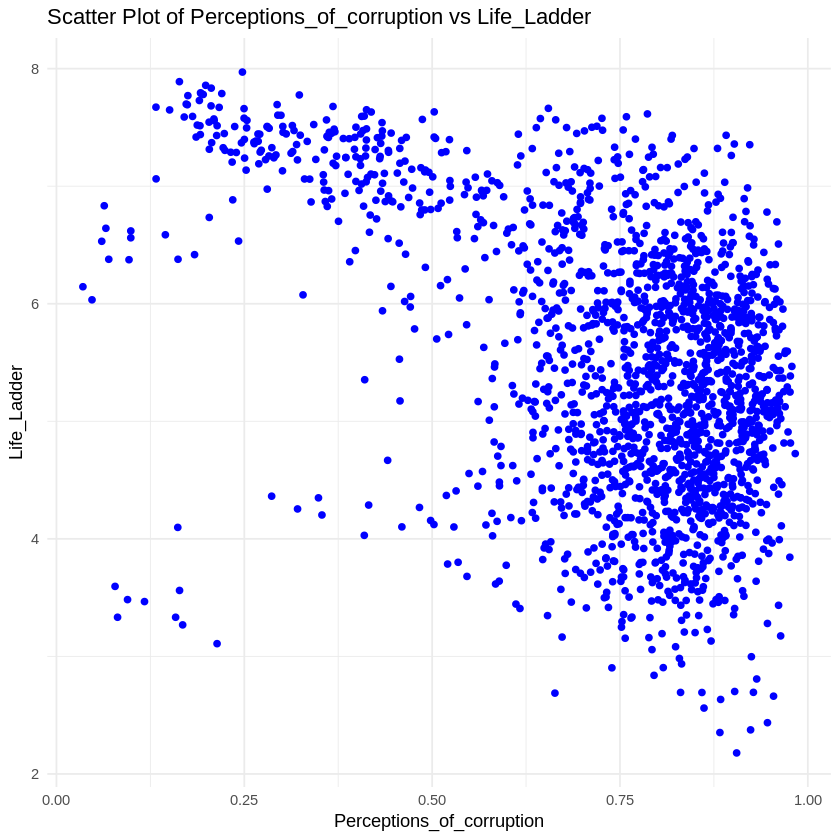

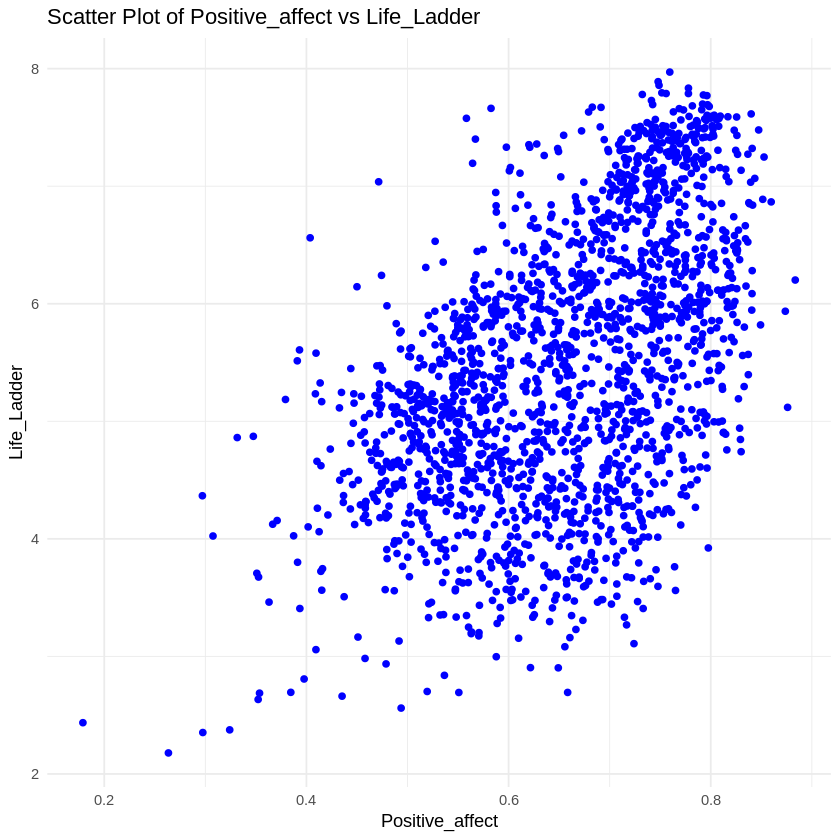

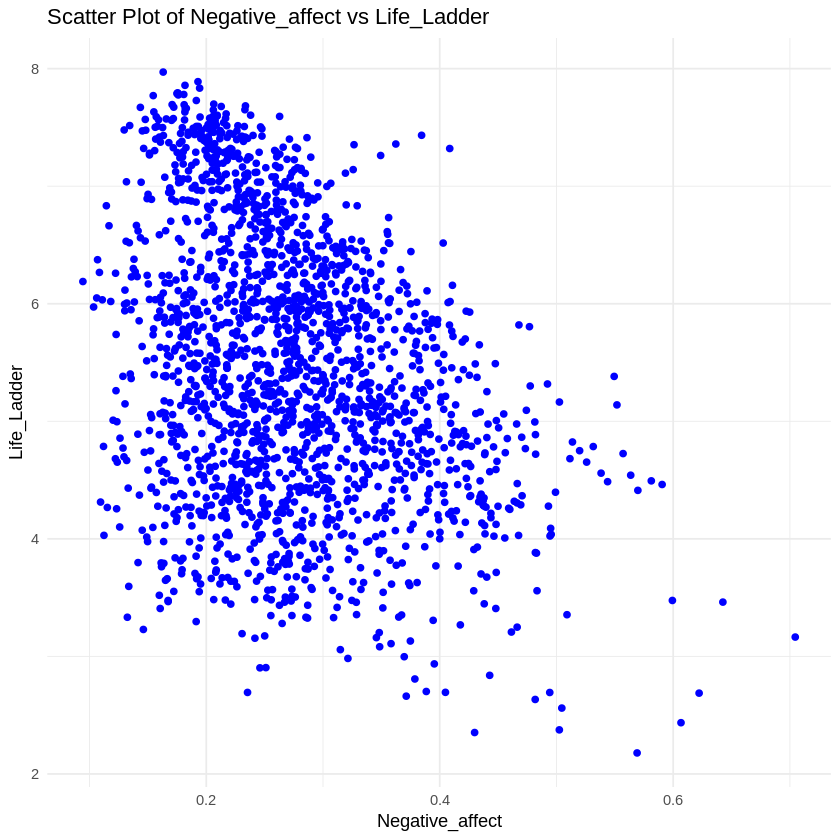

In [12]:
# Scatter Plots of All Predictors vs. Life_Ladder. To explore relationships between predictor variables and the response variable (Life_Ladder).
for (predictor in predictors) {
  plot <- ggplot(happiness_data_cleaned, aes_string(x = predictor, y = "Life_Ladder")) +
    geom_point(color = "blue") +
    labs(title = paste("Scatter Plot of", predictor, "vs Life_Ladder"), x = predictor, y = "Life_Ladder") +
    theme_minimal()
  print(plot)
}

In [13]:
# Create the Categorical Target Variable `Happiness_Level` with 4 classes
happiness_data_cleaned <- happiness_data_cleaned %>%
  mutate(Happiness_Level = case_when(
    Life_Ladder <= 4.5 ~ "very_unhappy",
    Life_Ladder > 4.5 & Life_Ladder <= 5.5 ~ "unhappy",
    Life_Ladder > 5.5 & Life_Ladder <= 6.5 ~ "happy",
    Life_Ladder > 6.5 ~ "very_happy"
  ))

# Convert Happiness_Level to factor
happiness_data_cleaned$Happiness_Level <- factor(
  happiness_data_cleaned$Happiness_Level,
  levels = c("very_unhappy", "unhappy", "happy", "very_happy")
)

# Display the first few rows to confirm changes
head(happiness_data_cleaned)

Country_name year Life_Ladder Log_GDP_per_capita Social_support
1 Afghanistan  2008 3.723590    7.350416           0.4506623     
2 Afghanistan  2009 4.401778    7.508646           0.5523084     
3 Afghanistan  2010 4.758381    7.613900           0.5390752     
4 Afghanistan  2011 3.831719    7.581259           0.5211036     
5 Afghanistan  2012 3.782938    7.660506           0.5206367     
6 Afghanistan  2013 3.572100    7.680333           0.4835519     
  Healthy_life_expectancy Freedom_to_make_life_choices Generosity
1 50.5                    0.7181143                    0.16765246
2 50.8                    0.6788964                    0.19080880
3 51.1                    0.6001272                    0.12131605
4 51.4                    0.4959014                    0.16357149
5 51.7                    0.5309350                    0.23758759
6 52.0                    0.5779554                    0.06266622
  Perceptions_of_corruption Positive_affect Negative_affect Happiness_Level
1 0.8816863                 0.4142970       0.2581955       very_unhappy   
2 0.8500354                 0.4814214       0.2370924       very_unhappy   
3 0.7067661                 0.5169067       0.2753238       unhappy        
4 0.7311085                 0.4798347       0.2671747       very_unhappy   
5 0.7756198                 0.6135128       0.2679191       very_unhappy   
6 0.8232041                 0.5474170       0.2733281       very_unhappy

In [14]:
# Check the distribution of Happiness_Level
table(happiness_data_cleaned$Happiness_Level)

cat("\n\n")

# Check new dimensions after adding target column Happiness_Level
dim(happiness_data_cleaned)

cat("\n\n")

# Split the data into training and testing sets
set.seed(123)  # For reproducibility
train_index <- createDataPartition(happiness_data_cleaned$Happiness_Level, p = 0.8, list = FALSE)
happiness_data_train <- happiness_data_cleaned[train_index, ]
happiness_data_test <- happiness_data_cleaned[-train_index, ]

# Check the distribution in training and testing sets
print("Train:")
table(happiness_data_train$Happiness_Level)
cat("\n")
print("Test:")
table(happiness_data_test$Happiness_Level)


very_unhappy      unhappy        happy   very_happy 
         437          598          523          400 

[1] 1958   12



[1] "Train:"



very_unhappy      unhappy        happy   very_happy 
         350          479          419          320 


[1] "Test:"



very_unhappy      unhappy        happy   very_happy 
          87          119          104           80 

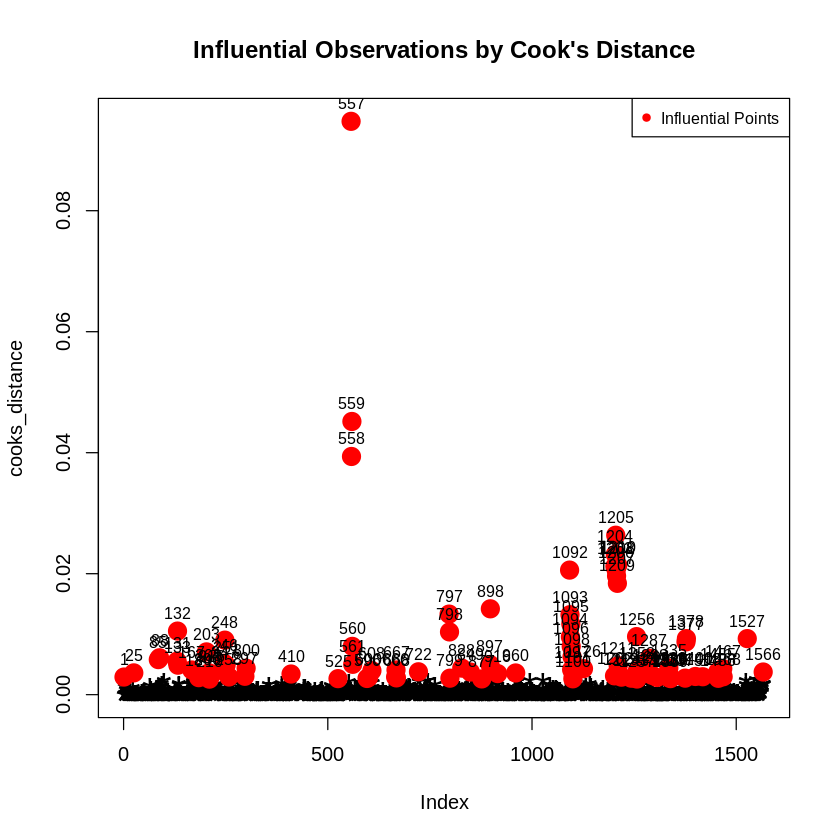

In [15]:
#.........Influential Points Detection using Cook's Distance.........#

# Fit a linear model to calculate Cook's Distance
lm_model <- lm(Life_Ladder ~ Social_support + Healthy_life_expectancy +
                 Freedom_to_make_life_choices + Perceptions_of_corruption +
                 Positive_affect + Negative_affect, data = happiness_data_train)

# Calculate Cook's Distance
cooks_distance <- cooks.distance(lm_model)

# Identify influential points (e.g., Cook's Distance > 4/n)
influential_points <- which(cooks_distance > (4 / nrow(happiness_data_train)))

# Plot influential points on the Cook's distance plot
plot(cooks_distance, pch="*", cex=2, main="Influential Observations by Cook's Distance")
points(influential_points, cooks_distance[influential_points], col="red", pch=19, cex=2)
# Add labels to the influential points (see their row numbers)
text(influential_points, cooks_distance[influential_points], labels=influential_points, pos=3, cex=0.8)
# Add a legend to explain the red points
legend("topright", legend=c("Influential Points"), col="red", pch=19, cex=0.8)

# Remove influential points from the training set
happiness_data_train_cleaned <- happiness_data_train[-influential_points, ]

**############ Step 2: Model Building (Applying Supervised Models) ############**

In [16]:
### Model 1: Multiple Linear Regression ###

# Train Multiple Linear Regression Model
model_multiple_linear <- lm(Life_Ladder ~ Social_support + Healthy_life_expectancy +
                              Freedom_to_make_life_choices + Perceptions_of_corruption +
                              Positive_affect + Negative_affect,
                            data = happiness_data_train_cleaned)

# Print model summary
summary(model_multiple_linear)

# Extract Adjusted R-squared from model summary
adjusted_r_squared_multiple_linear <- summary(model_multiple_linear)$adj.r.squared

# Calculate AIC
aic_multiple_linear <- AIC(model_multiple_linear)

# Extract standard errors and p-values
std_errors <- summary(model_multiple_linear)$coefficients[, "Std. Error"]
p_values <- summary(model_multiple_linear)$coefficients[, "Pr(>|t|)"]

# Print standard errors and p-values
cat("Standard Errors:\n")
print(std_errors)
cat("P-values:\n")
print(p_values)


Call:
lm(formula = Life_Ladder ~ Social_support + Healthy_life_expectancy + 
    Freedom_to_make_life_choices + Perceptions_of_corruption + 
    Positive_affect + Negative_affect, data = happiness_data_train_cleaned)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.69678 -0.29519  0.01586  0.31148  1.53298 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  -2.815103   0.191582 -14.694  < 2e-16 ***
Social_support                3.190293   0.159679  19.979  < 2e-16 ***
Healthy_life_expectancy       0.073271   0.002531  28.948  < 2e-16 ***
Freedom_to_make_life_choices  0.584598   0.126140   4.635 3.89e-06 ***
Perceptions_of_corruption    -1.062507   0.081219 -13.082  < 2e-16 ***
Positive_affect               2.180554   0.154941  14.073  < 2e-16 ***
Negative_affect               0.007337   0.176949   0.041    0.967    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.

Standard Errors:
                 (Intercept)               Social_support 
                 0.191582261                  0.159678840 
     Healthy_life_expectancy Freedom_to_make_life_choices 
                 0.002531157                  0.126139560 
   Perceptions_of_corruption              Positive_affect 
                 0.081219434                  0.154941326 
             Negative_affect 
                 0.176949110 
P-values:
                 (Intercept)               Social_support 
                1.039868e-45                 9.276904e-79 
     Healthy_life_expectancy Freedom_to_make_life_choices 
               3.487710e-146                 3.894208e-06 
   Perceptions_of_corruption              Positive_affect 
                4.502312e-37                 2.698954e-42 
             Negative_affect 
                9.669314e-01 


In [17]:
### Model 2: Multinomial Logistic Regression ###

# Train Multinomial Logistic Regression Model
model_multinomial <- multinom(Happiness_Level ~ Social_support + Healthy_life_expectancy +
                                Freedom_to_make_life_choices + Perceptions_of_corruption +
                                Positive_affect + Negative_affect,
                              data = happiness_data_train_cleaned)

# Print model summary
summary(model_multinomial)

# Extract standard errors and p-values
std_errors_multinomial <- summary(model_multinomial)$standard.errors
p_values_multinomial <- summary(model_multinomial)$coefficients / std_errors_multinomial
p_values_multinomial <- 2 * (1 - pnorm(abs(p_values_multinomial)))

# Print p-values
cat("Multinomial Logistic Regression P-values:\n")
print(p_values_multinomial)

# weights:  32 (21 variable)
initial  value 2047.556771 
iter  10 value 1204.416418
iter  20 value 970.552761
iter  30 value 966.104969
final  value 966.095695 
converged


Call:
multinom(formula = Happiness_Level ~ Social_support + Healthy_life_expectancy + 
    Freedom_to_make_life_choices + Perceptions_of_corruption + 
    Positive_affect + Negative_affect, data = happiness_data_train_cleaned)

Coefficients:
           (Intercept) Social_support Healthy_life_expectancy
unhappy      -21.06277       7.211853               0.1597252
happy        -55.83249      21.636347               0.4592762
very_happy  -102.57214      42.692820               0.7843824
           Freedom_to_make_life_choices Perceptions_of_corruption
unhappy                        2.951461                  2.152743
happy                          4.654056                 -0.500370
very_happy                     3.929252                 -5.878735
           Positive_affect Negative_affect
unhappy           4.152397       1.8944526
happy            11.483847       0.2193551
very_happy       25.079968      -0.2788118

Std. Errors:
           (Intercept) Social_support Healthy_life_expectanc

Multinomial Logistic Regression P-values:
           (Intercept) Social_support Healthy_life_expectancy
unhappy              0   6.567635e-12                       0
happy                0   0.000000e+00                       0
very_happy           0   0.000000e+00                       0
           Freedom_to_make_life_choices Perceptions_of_corruption
unhappy                    0.0002346056              0.0268263913
happy                      0.0001101350              0.7093790335
very_happy                 0.0371373774              0.0001071327
           Positive_affect Negative_affect
unhappy       2.873045e-04      0.07816642
happy         1.609823e-13      0.89958601
very_happy    0.000000e+00      0.91532926


In [18]:
##### Model 3: Ridge Regression #####

# Prepare the data for Ridge Regression
x_train_cleaned <- model.matrix(Life_Ladder ~ Social_support + Healthy_life_expectancy +
                                  Freedom_to_make_life_choices + Perceptions_of_corruption +
                                  Positive_affect + Negative_affect,
                                data = happiness_data_train_cleaned)[, -1]
y_train_cleaned <- happiness_data_train_cleaned$Life_Ladder

# Fit the Ridge Regression model
ridge_model <- glmnet(x_train_cleaned, y_train_cleaned, alpha = 0)

# Perform cross-validation to find the optimal lambda
cv_ridge <- cv.glmnet(x_train_cleaned, y_train_cleaned, alpha = 0)
best_lambda_ridge <- cv_ridge$lambda.min

# Print the best lambda value
print(best_lambda_ridge)

# Fit the Ridge Regression model with the best lambda
ridge_model_best <- glmnet(x_train_cleaned, y_train_cleaned, alpha = 0, lambda = best_lambda_ridge)

##### Ridge Regression Coefficients, RMSE, and R^2 #####

# Extract Ridge Regression Coefficients
ridge_coefficients <- coef(ridge_model_best)  # Extract coefficients for optimal lambda
cat("\nRidge Coefficients (All Values):\n")
print(ridge_coefficients)

# Filter non-zero coefficients for Ridge Regression
ridge_non_zero_coefficients <- ridge_coefficients[ridge_coefficients != 0]
cat("\nRidge Coefficients (Non-Zero Values):\n")
print(ridge_non_zero_coefficients)

# Prepare the test data for Ridge Regression (Fix)
x_test_cleaned <- model.matrix(Life_Ladder ~ Social_support + Healthy_life_expectancy +
                                  Freedom_to_make_life_choices + Perceptions_of_corruption +
                                  Positive_affect + Negative_affect,
                                data = happiness_data_test)[, -1]

# Calculate RMSE for Ridge Regression
predictions_ridge <- predict(ridge_model_best, s = best_lambda_ridge, newx = x_test_cleaned)
ridge_rmse <- sqrt(mean((predictions_ridge - happiness_data_test$Life_Ladder)^2))
cat("\nRidge RMSE:", ridge_rmse, "\n")

# Calculate R^2 for Ridge Regression
ss_total <- sum((happiness_data_test$Life_Ladder - mean(happiness_data_test$Life_Ladder))^2)  # Total sum of squares
ss_residual <- sum((happiness_data_test$Life_Ladder - predictions_ridge)^2)  # Residual sum of squares
ridge_r_squared <- 1 - (ss_residual / ss_total)
cat("\nRidge R^2:", ridge_r_squared, "\n")

[1] 0.08492348

Ridge Coefficients (All Values):
7 x 1 sparse Matrix of class "dgCMatrix"
                                      s0
(Intercept)                  -2.43468665
Social_support                3.07312167
Healthy_life_expectancy       0.06897239
Freedom_to_make_life_choices  0.71568987
Perceptions_of_corruption    -1.01645741
Positive_affect               2.02420916
Negative_affect              -0.14695698

Ridge Coefficients (Non-Zero Values):
[1] -2.43468665  3.07312167  0.06897239  0.71568987 -1.01645741  2.02420916
[7] -0.14695698

Ridge RMSE: 0.580646 

Ridge R^2: 0.7409072 


**########## Step 3: Assess Model Performance (Evaluation of Results) ############**

In [19]:
### Model Assessment: Multiple Linear Regression ###

# Predictions on the test set
predictions_multiple_linear <- predict(model_multiple_linear, newdata = happiness_data_test)

# Calculate RMSE (Root Mean Squared Error)
rmse_multiple_linear <- sqrt(mean((predictions_multiple_linear - happiness_data_test$Life_Ladder)^2))

# Display Evaluation Metrics for Multiple Linear Regression
cat("\nMultiple Linear Regression Metrics:\n")
cat("RMSE:", rmse_multiple_linear, "\n")
cat("Adjusted R-squared:", adjusted_r_squared_multiple_linear, "\n") # Adjusted R^2
cat("AIC:", aic_multiple_linear, "\n") # AIC


Multiple Linear Regression Metrics:
RMSE: 0.585291 
Adjusted R-squared: 0.8173409 
AIC: 2013.016 


              Reference
Predicted      very_unhappy unhappy happy very_happy
  very_unhappy           55      23     1          0
  unhappy                29      71    14          0
  happy                   3      25    72         25
  very_happy              0       0    17         55

Multinomial Logistic Regression Metrics:
Accuracy: 0.6487179 
Precision:
very_unhappy      unhappy        happy   very_happy 
       0.696        0.623        0.576        0.764 
Recall:
very_unhappy      unhappy        happy   very_happy 
       0.632        0.597        0.692        0.688 
F1-Score:
very_unhappy      unhappy        happy   very_happy 
       0.663        0.609        0.629        0.724 


Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



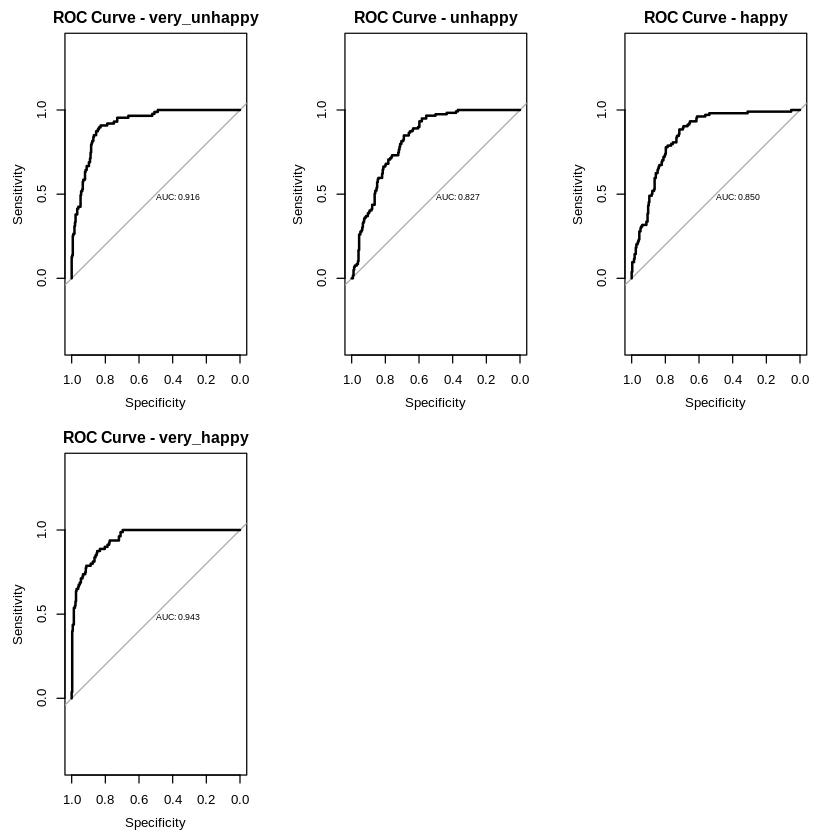

In [20]:
### Model Assessment: Multinomial Logistic Regression ###

# Predict probabilities for each class
probabilities_multinomial <- predict(model_multinomial, newdata = happiness_data_test, type = "probs")

# Predict classes for the test set
predictions_multinomial <- predict(model_multinomial, newdata = happiness_data_test)

# Create confusion matrix
confusionMatrix_multinomial <- table(Predicted = predictions_multinomial, Reference = happiness_data_test$Happiness_Level)
print(confusionMatrix_multinomial)

# Calculate accuracy
accuracy_multinomial <- mean(predictions_multinomial == happiness_data_test$Happiness_Level)

# Calculate Precision, Recall, and F1-Score for each class
precision_multinomial <- diag(confusionMatrix_multinomial) / rowSums(confusionMatrix_multinomial)
recall_multinomial <- diag(confusionMatrix_multinomial) / colSums(confusionMatrix_multinomial)
f1_score_multinomial <- 2 * precision_multinomial * recall_multinomial / (precision_multinomial + recall_multinomial)

# Display Evaluation Metrics for Multinomial Logistic Regression
cat("\nMultinomial Logistic Regression Metrics:\n")
cat("Accuracy:", accuracy_multinomial, "\n")
cat("Precision:\n")
print(round(precision_multinomial, 3))
cat("Recall:\n")
print(round(recall_multinomial, 3))
cat("F1-Score:\n")
print(round(f1_score_multinomial, 3))

# Convert Happiness_Level to numeric for ROC analysis
happiness_data_test$Happiness_Level_numeric <- as.numeric(happiness_data_test$Happiness_Level)

# Initialize a list to store ROC curves
roc_curves <- list()

# Plot ROC curves for each class
par(mfrow = c(2, 3))  # Set up the plotting area to have 2 rows and 3 columns
for (i in 1:nlevels(happiness_data_test$Happiness_Level)) {
  roc_curves[[i]] <- roc(happiness_data_test$Happiness_Level_numeric == i, probabilities_multinomial[, i])
  plot(roc_curves[[i]], main = paste("ROC Curve -", levels(happiness_data_test$Happiness_Level)[i]), print.auc = TRUE)
}

In [21]:
### Model Assessment: Ridge Regression ###
# Predict on the test set
x_test <- model.matrix(Life_Ladder ~ Social_support + Healthy_life_expectancy +
                         Freedom_to_make_life_choices + Perceptions_of_corruption +
                         Positive_affect + Negative_affect,
                       data = happiness_data_test)[, -1]
ridge_predictions <- predict(ridge_model_best, s = best_lambda_ridge, newx = x_test)

# Calculate RMSE for Ridge Regression
rmse_ridge <- sqrt(mean((ridge_predictions - happiness_data_test$Life_Ladder)^2))
print(rmse_ridge)

[1] 0.580646


**##################### Step 4: Result Interpretation ###########################**

Multiple Linear Regression Feature Importance (T-Values):
                                                Predictor      T_Value
Healthy_life_expectancy           Healthy_life_expectancy  28.94761492
Social_support                             Social_support  19.97943535
Positive_affect                           Positive_affect  14.07342007
Perceptions_of_corruption       Perceptions_of_corruption -13.08192629
Freedom_to_make_life_choices Freedom_to_make_life_choices   4.63453110
Negative_affect                           Negative_affect   0.04146423
                             Abs_T_Value
Healthy_life_expectancy      28.94761492
Social_support               19.97943535
Positive_affect              14.07342007
Perceptions_of_corruption    13.08192629
Freedom_to_make_life_choices  4.63453110
Negative_affect               0.04146423


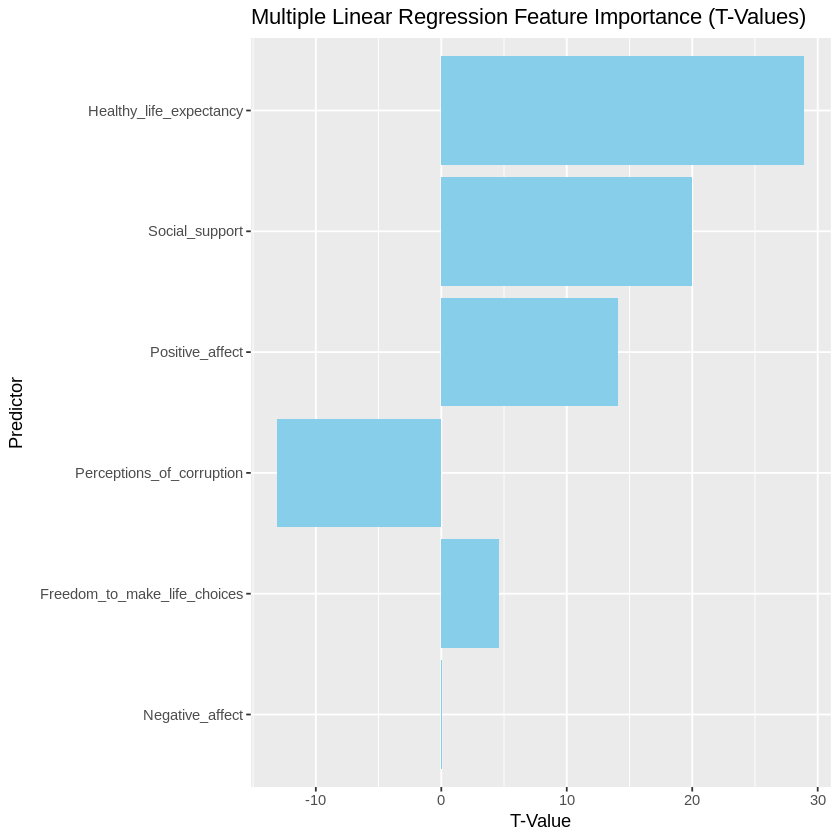

In [22]:
### Multiple Linear Regression Feature Importance ###

# Extract t-values from the multiple linear regression model
summary_multiple_linear <- summary(model_multiple_linear)
t_values <- summary_multiple_linear$coefficients[, "t value"] # Extract only t-values

# Create a table with Predictor and T-value
coef_table_multiple_linear <- data.frame(
  Predictor = rownames(summary_multiple_linear$coefficients),
  T_Value = t_values,
  Abs_T_Value = abs(t_values) # Absolute T-values for ranking
)

# Exclude the intercept
coef_table_multiple_linear <- coef_table_multiple_linear[coef_table_multiple_linear$Predictor != "(Intercept)", ]

# Sort the table by absolute T-value (descending order) to get feature importance ranking
coef_table_sorted_multiple_linear <- coef_table_multiple_linear[order(-coef_table_multiple_linear$Abs_T_Value), ]

# Show sorted table with T-values
cat("Multiple Linear Regression Feature Importance (T-Values):\n")
print(coef_table_sorted_multiple_linear)

# Visualize Feature Importance based on T-values
ggplot(coef_table_sorted_multiple_linear, aes(x = reorder(Predictor, Abs_T_Value), y = T_Value)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  coord_flip() +
  labs(x = "Predictor", y = "T-Value") +
  ggtitle("Multiple Linear Regression Feature Importance (T-Values)")

Mean of residuals: 1.565553e-17 


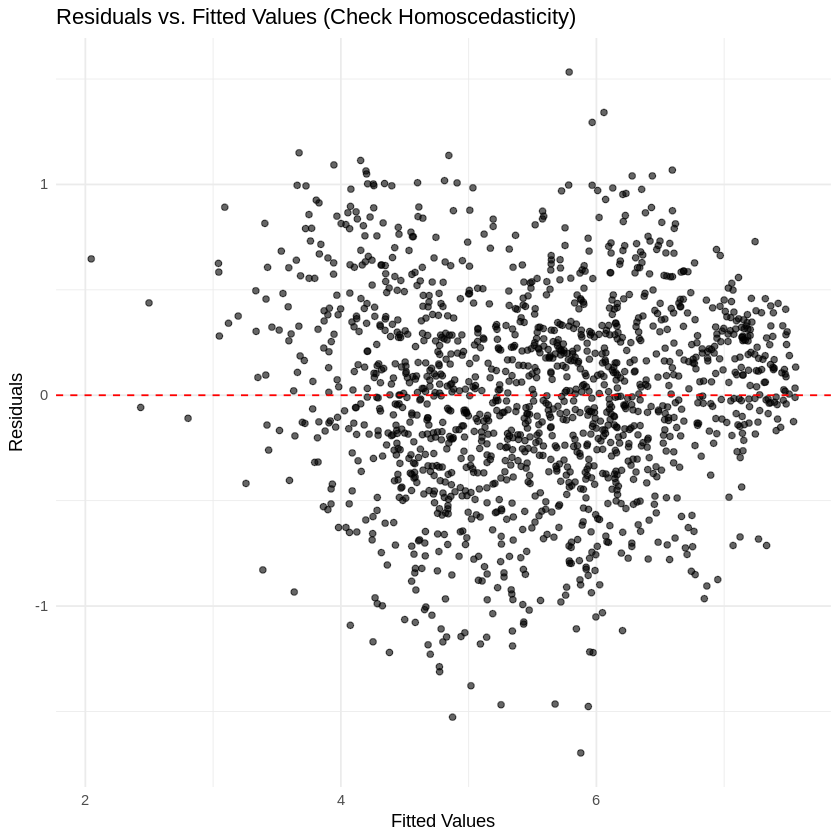

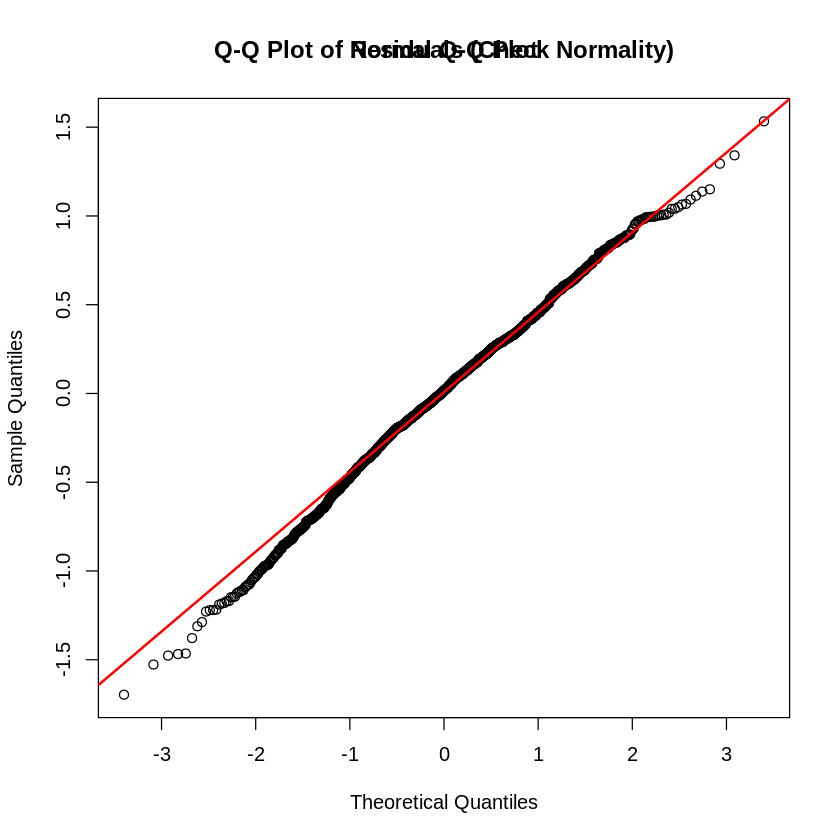

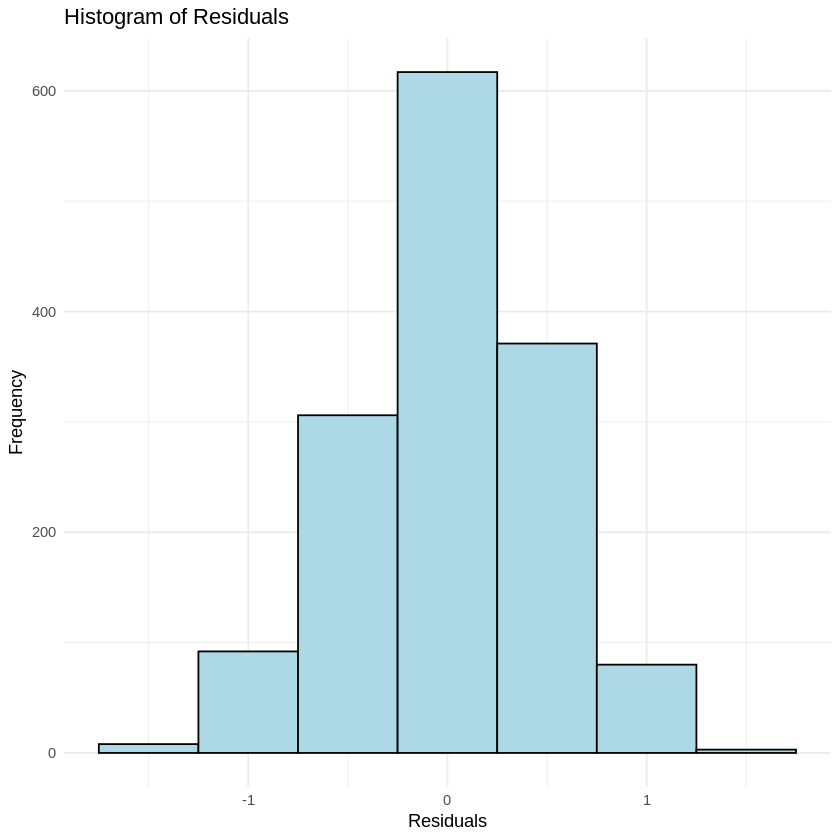

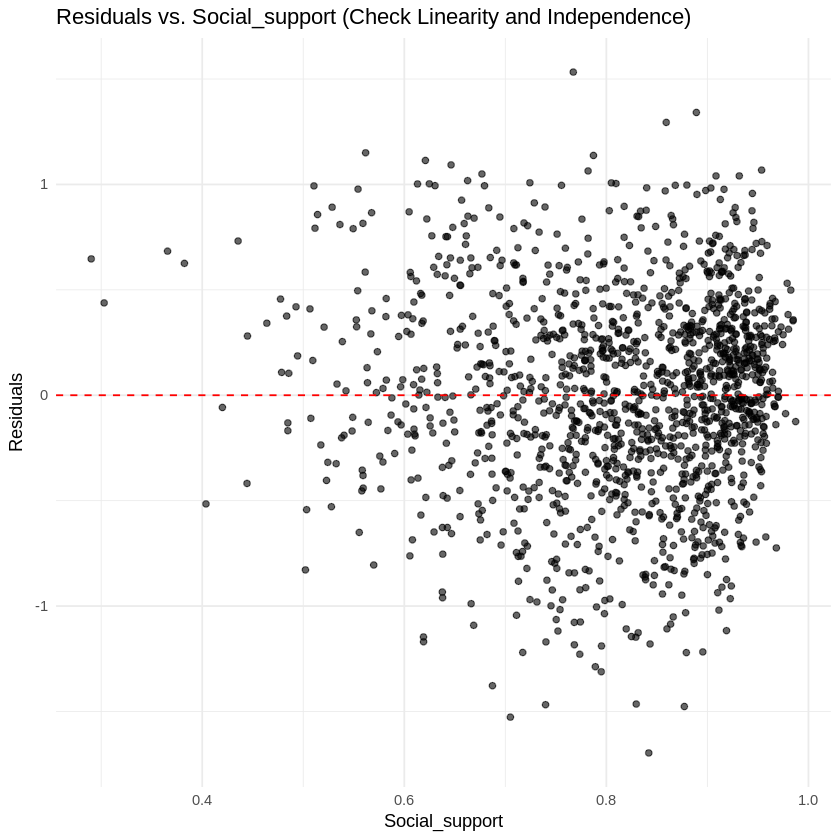

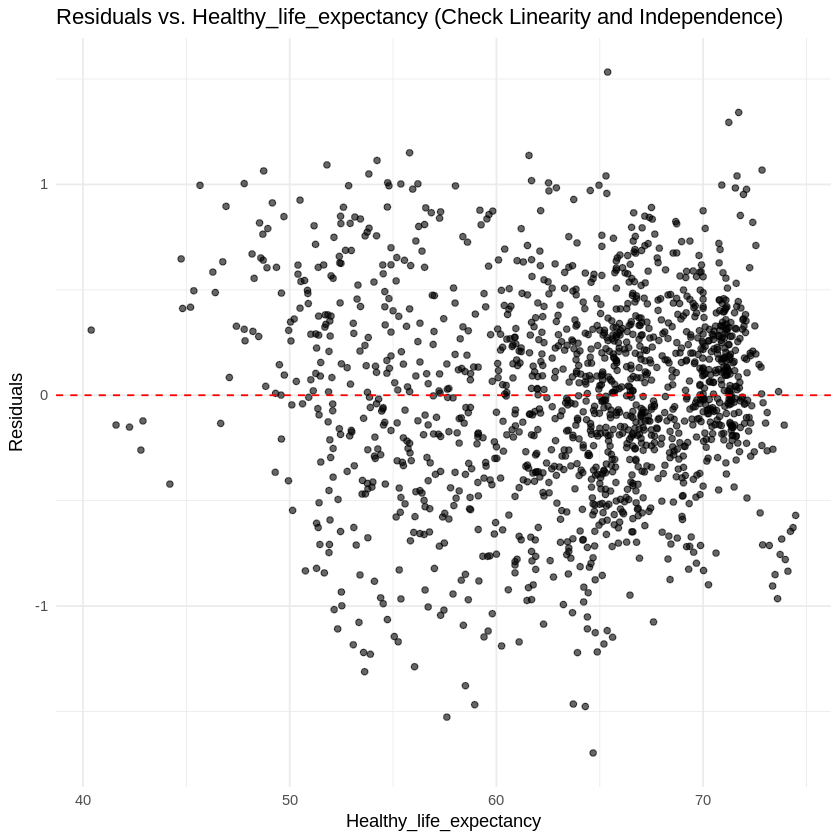

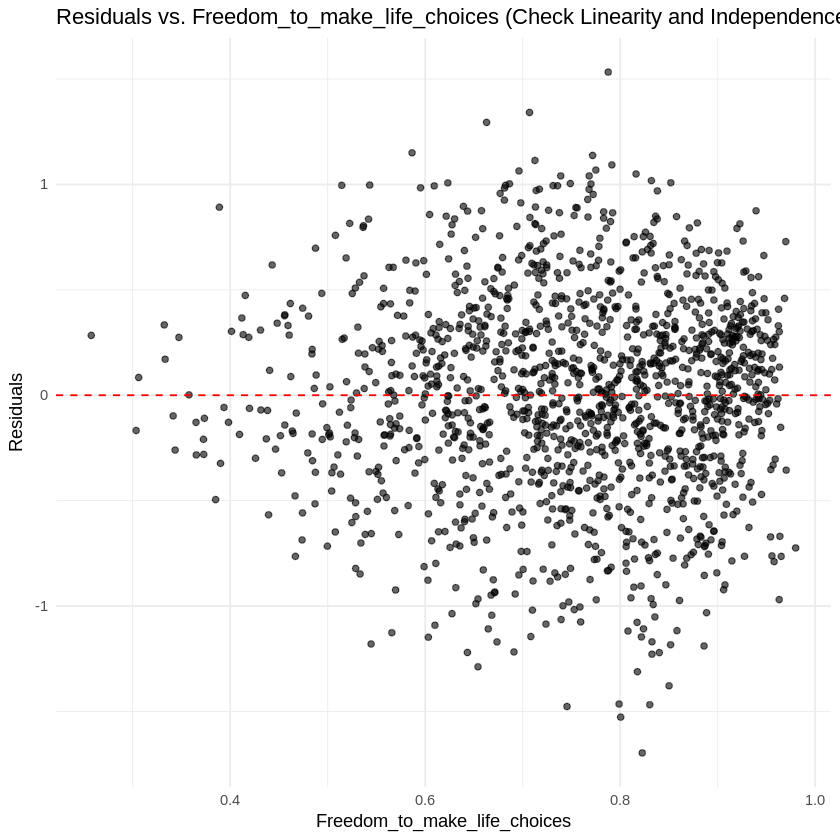

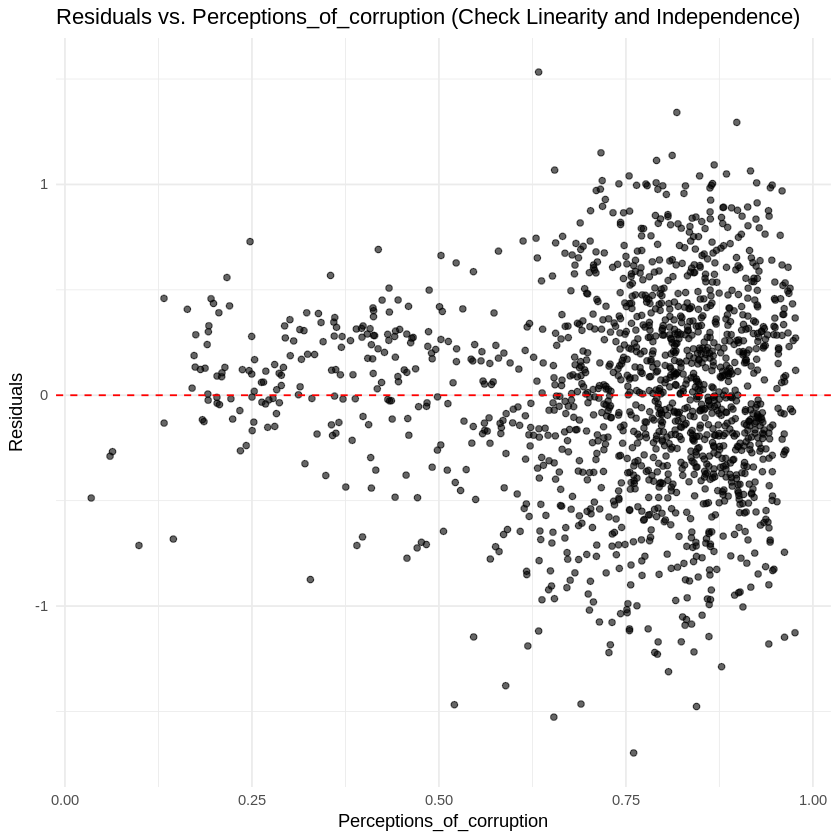

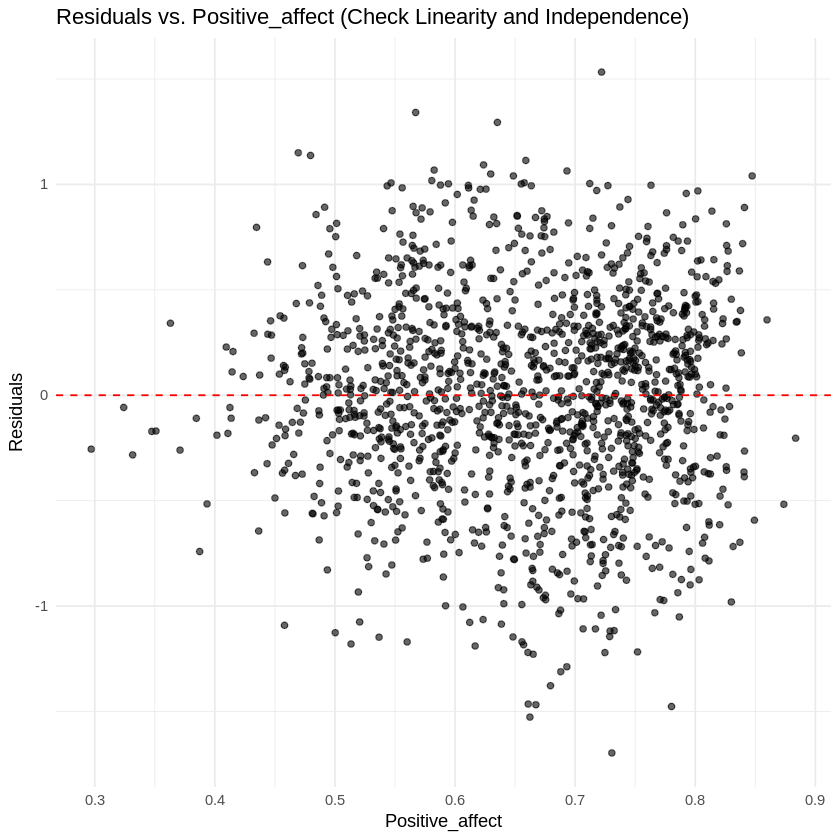

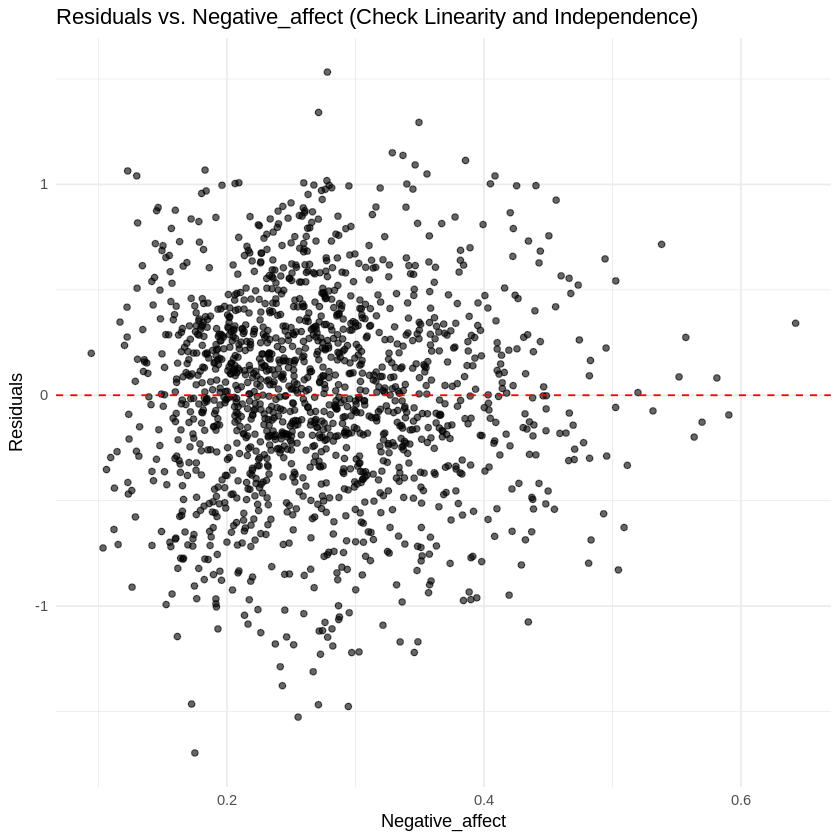

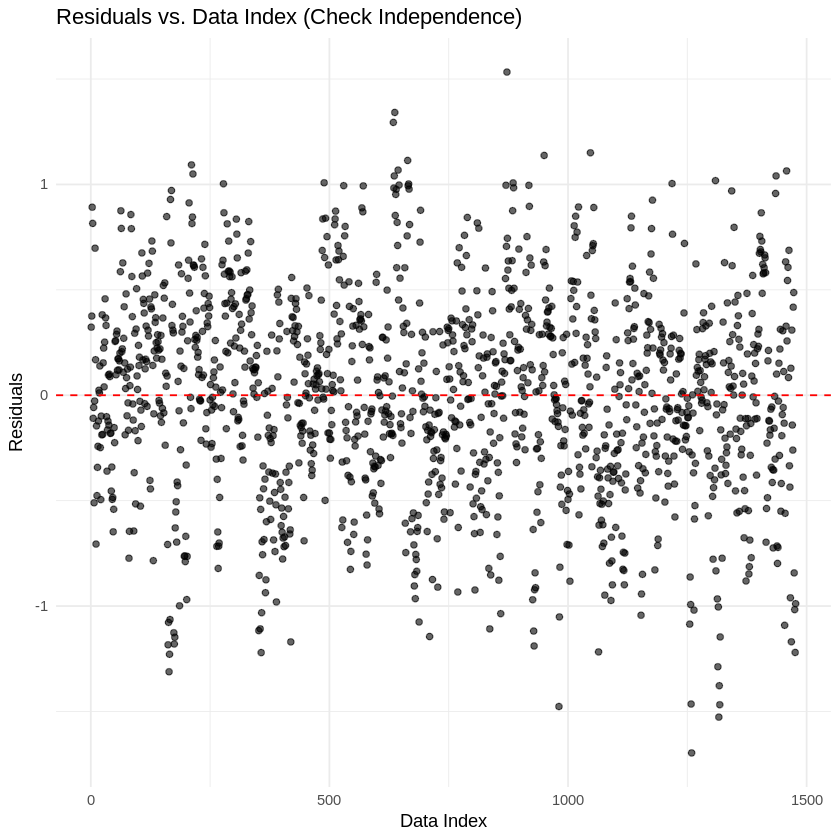

In [23]:
############### Multiple Linear Regression Residual Analysis ###############

# 1. Calculate Residuals and Fitted Values
residuals_multiple_linear <- residuals(model_multiple_linear)
fitted_values_multiple_linear <- fitted(model_multiple_linear)

# 2. Check Zero Mean of Residuals
mean_residuals <- mean(residuals_multiple_linear)
cat("Mean of residuals:", mean_residuals, "\n")  # Should be close to zero

# 3. Residuals vs. Fitted Values Plot (Check Homoscedasticity)
# This plot helps check for constant variance of residuals
ggplot(data = data.frame(Fitted = fitted_values_multiple_linear, Residuals = residuals_multiple_linear),
       aes(x = Fitted, y = Residuals)) +
  geom_point(alpha = 0.6) +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
  labs(title = "Residuals vs. Fitted Values (Check Homoscedasticity)", x = "Fitted Values", y = "Residuals") +
  theme_minimal()

# 4. Q-Q Plot of Residuals (Check Normality)
# This plot checks if residuals follow a normal distribution
qqnorm(residuals_multiple_linear)
qqline(residuals_multiple_linear, col = "red", lwd = 2)
title("Q-Q Plot of Residuals (Check Normality)")

# 5. Histogram of Residuals (Additional Check for Normality)
# This plot helps visually inspect the distribution of residuals
ggplot(data = data.frame(Residuals = residuals_multiple_linear), aes(x = Residuals)) +
  geom_histogram(binwidth = 0.5, fill = "lightblue", color = "black") +
  labs(title = "Histogram of Residuals", x = "Residuals", y = "Frequency") +
  theme_minimal()

# 6. Residuals vs. Each Predictor (Check for Independence and Linearity)
# This checks if there are any patterns in residuals against individual predictors
predictors <- c("Social_support", "Healthy_life_expectancy", "Freedom_to_make_life_choices",
                "Perceptions_of_corruption", "Positive_affect", "Negative_affect")

# Loop through each predictor and plot residuals
for (predictor in predictors) {
  plot <- ggplot(data = data.frame(Predictor = happiness_data_train_cleaned[[predictor]], Residuals = residuals_multiple_linear),
                 aes(x = Predictor, y = Residuals)) +
    geom_point(alpha = 0.6) +
    geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
    labs(title = paste("Residuals vs.", predictor, "(Check Linearity and Independence)"), x = predictor, y = "Residuals") +
    theme_minimal()
  print(plot)  # Print each plot
}

# 7. Residuals vs. Data Index (Check for Independence)
# This plot checks for patterns that may indicate lack of independence
data_index <- seq_along(residuals_multiple_linear)
ggplot(data = data.frame(Index = data_index, Residuals = residuals_multiple_linear), aes(x = Index, y = Residuals)) +
  geom_point(alpha = 0.6) +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
  labs(title = "Residuals vs. Data Index (Check Independence)", x = "Data Index", y = "Residuals") +
  theme_minimal()


`summarise()` has grouped output by 'Class'. You can override using the
`.groups` argument.


Multinomial Logistic Regression Feature Importance (Z-Scores):
# A tibble: 18 × 6
   Class      Predictor                Coefficient Std_Error Z_Score Abs_Z_Score
   <chr>      <chr>                          <dbl>     <dbl>   <dbl>       <dbl>
 1 happy      Healthy_life_expectancy        0.459    0.0336  13.7        13.7  
 2 happy      Social_support                21.6      2.00    10.8        10.8  
 3 happy      Positive_affect               11.5      1.56     7.38        7.38 
 4 happy      Freedom_to_make_life_ch…       4.65     1.20     3.87        3.87 
 5 happy      Perceptions_of_corrupti…      -0.500    1.34    -0.373       0.373
 6 happy      Negative_affect                0.219    1.74     0.126       0.126
 7 unhappy    Healthy_life_expectancy        0.160    0.0182   8.76        8.76 
 8 unhappy    Social_support                 7.21     1.05     6.87        6.87 
 9 unhappy    Freedom_to_make_life_ch…       2.95     0.802    3.68        3.68 
10 unhappy    Positive_affe

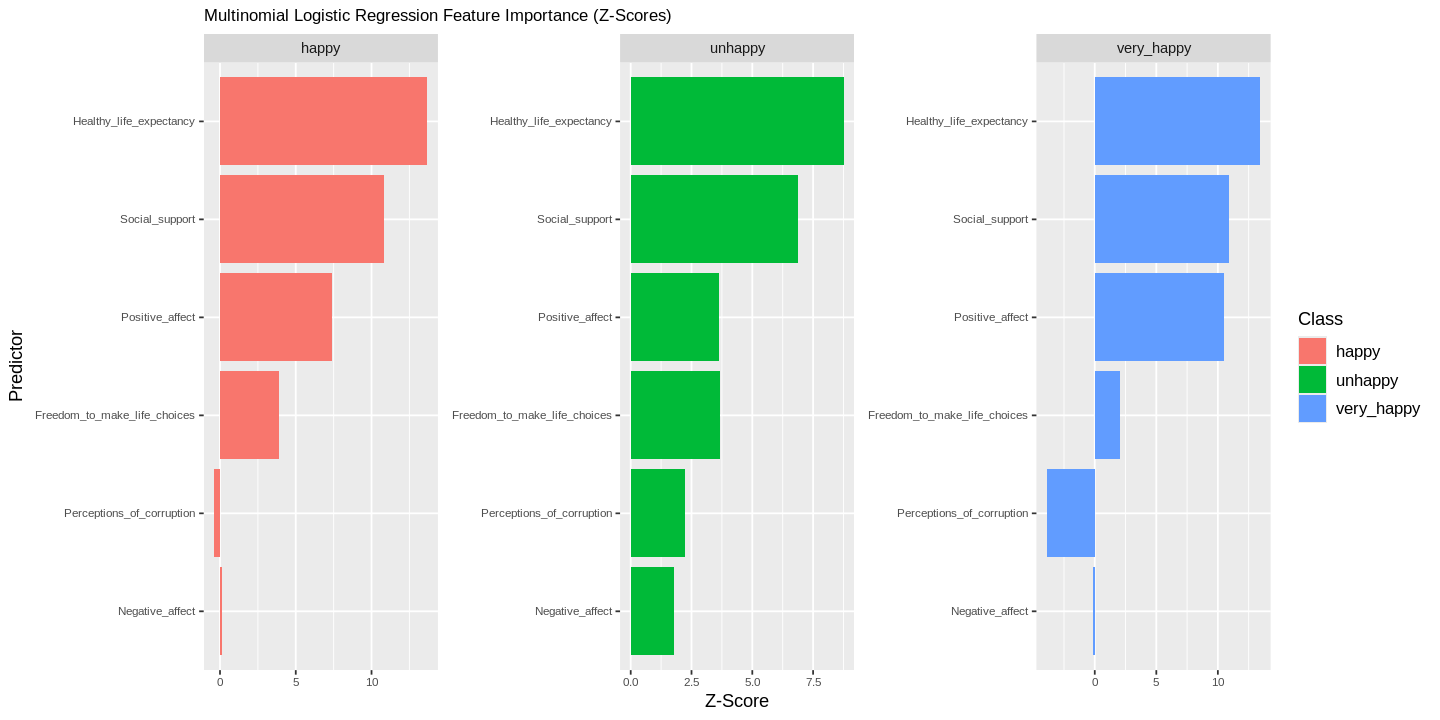

In [32]:
########### Multinomial Logistic Regression Feature Importance ########

# Extract coefficients and standard errors from the multinomial logistic regression model
summary_multinomial <- summary(model_multinomial)
coefs_multinomial <- summary_multinomial$coefficients
std_errors_multinomial <- summary_multinomial$standard.errors

# Create a table with coefficients, standard errors, and approximate z-scores for each class
coef_table_multinomial <- data.frame()
for (i in 1:nrow(coefs_multinomial)) {
  coefs <- coefs_multinomial[i, ]
  std_errors <- std_errors_multinomial[i, ]
  z_scores <- coefs / std_errors  # Calculate approximate z-scores
  coef_table <- data.frame(
    Predictor = names(coefs),
    Coefficient = coefs,
    Std_Error = std_errors,  # Include standard errors
    Z_Score = z_scores,  # Include z-scores for ranking
    Abs_Z_Score = abs(z_scores)  # Absolute z-scores for importance ranking
  )
  coef_table$Class <- rownames(coefs_multinomial)[i]
  coef_table_multinomial <- rbind(coef_table_multinomial, coef_table)
}

# Exclude the intercept
coef_table_multinomial <- coef_table_multinomial[coef_table_multinomial$Predictor != "(Intercept)", ]

# Deduplicate Predictor names based on Class to avoid ambiguity
coef_table_multinomial <- coef_table_multinomial %>%
  group_by(Class, Predictor) %>%
  summarise(
    Coefficient = first(Coefficient),  # Take the first occurrence (if duplicates exist)
    Std_Error = first(Std_Error),
    Z_Score = first(Z_Score),
    Abs_Z_Score = first(Abs_Z_Score)
  ) %>%
  ungroup()

# Sort the table by absolute z-score (descending order) for each class
coef_table_sorted_multinomial <- coef_table_multinomial %>%
  arrange(Class, desc(Abs_Z_Score))

# Show sorted table with Z-scores for each class
cat("Multinomial Logistic Regression Feature Importance (Z-Scores):\n")
print(coef_table_sorted_multinomial)





# Visualize Feature Importance based on Z-scores for each class
# Set plot size
options(repr.plot.width = 12, repr.plot.height = 6)

ggplot(coef_table_sorted_multinomial, aes(x = reorder(Predictor, Abs_Z_Score), y = Z_Score, fill = Class)) +
  geom_bar(stat = "identity", position = "dodge") +
  coord_flip() +
  labs(x = "Predictor", y = "Z-Score") +
  ggtitle("Multinomial Logistic Regression Feature Importance (Z-Scores)") +
  facet_wrap(~ Class, scales = "free") +
  theme(
    plot.title = element_text(size = 10),
    axis.text = element_text(size = 7),
    legend.text = element_text(size = 10)
  )

**############# Step 5: Comparative Analysis #############**

In [33]:
######### Comparing Polynomial Regression with Multiple Linear Regression #########

# Fit Polynomial Regression (Adding quadratic terms for selected predictors)
poly_model <- lm(Life_Ladder ~ poly(Social_support, 2) + poly(Healthy_life_expectancy, 2) +
                 poly(Freedom_to_make_life_choices, 2) + poly(Perceptions_of_corruption, 2) +
                 poly(Positive_affect, 2) + poly(Negative_affect, 2),
                 data = happiness_data_train_cleaned)

# Predictions for Polynomial Regression
predictions_poly <- predict(poly_model, newdata = happiness_data_test)

# Calculate RMSE for Polynomial Regression
rmse_poly <- sqrt(mean((predictions_poly - happiness_data_test$Life_Ladder)^2))

# Extract Adjusted R-squared for Polynomial Regression
adjusted_r_squared_poly <- summary(poly_model)$adj.r.squared

# Calculate AIC for Polynomial Regression
aic_poly <- AIC(poly_model)

# Print Comparison of Evaluation Metrics
cat("\nComparison of Evaluation Metrics:\n")
cat("Multiple Linear Regression:\n")
cat("  RMSE:", rmse_multiple_linear, "\n")
cat("  Adjusted R^2:", adjusted_r_squared_multiple_linear, "\n") # Adjusted R^2
cat("  AIC:", aic_multiple_linear, "\n") # AIC for Multiple Linear Regression
cat("Polynomial Regression:\n")
cat("  RMSE:", rmse_poly, "\n")
cat("  Adjusted R^2:", adjusted_r_squared_poly, "\n") # Adjusted R^2 for Polynomial Regression
cat("  AIC:", aic_poly, "\n") # AIC for Polynomial Regression


Comparison of Evaluation Metrics:
Multiple Linear Regression:
  RMSE: 0.585291 
  Adjusted R^2: 0.8173409 
  AIC: 2013.016 
Polynomial Regression:
  RMSE: 0.5429971 
  Adjusted R^2: 0.8268002 
  AIC: 1940.435 


Mean of residuals (Polynomial Regression): -4.329028e-18 


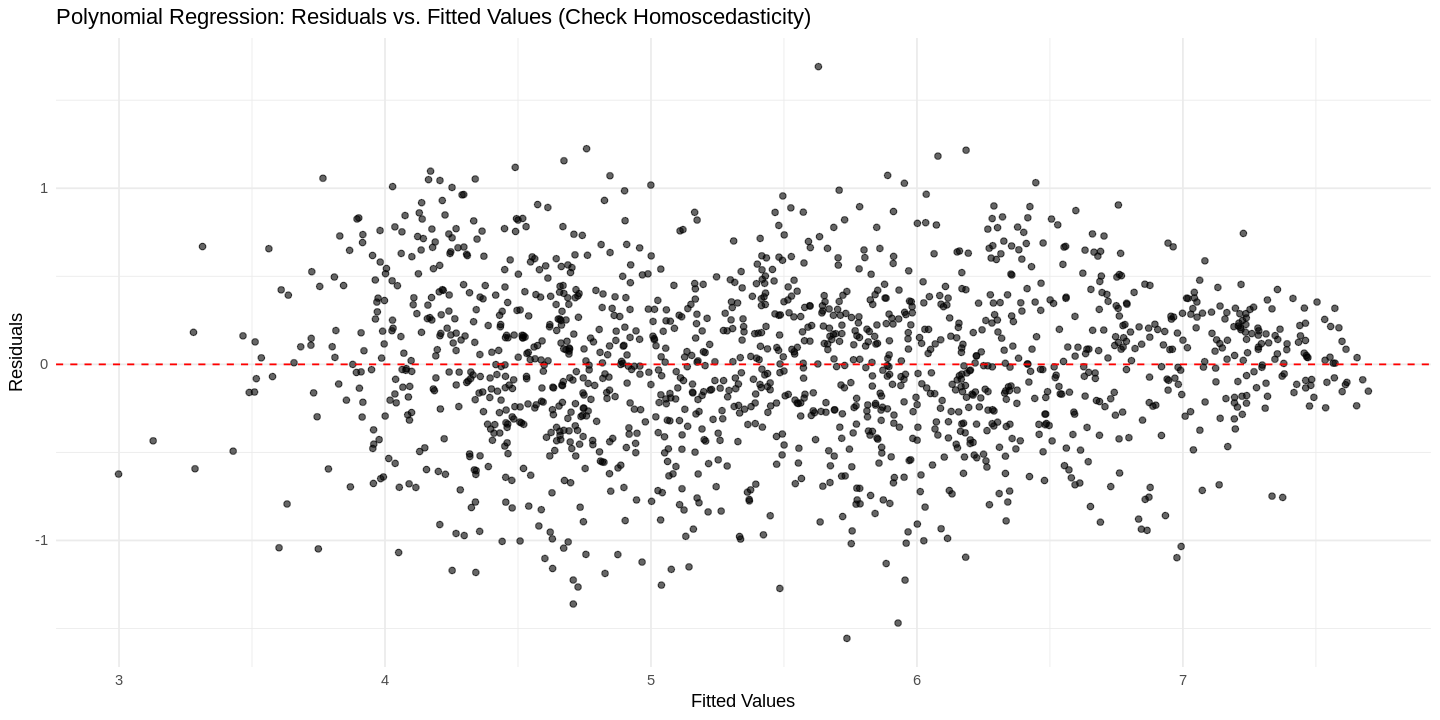

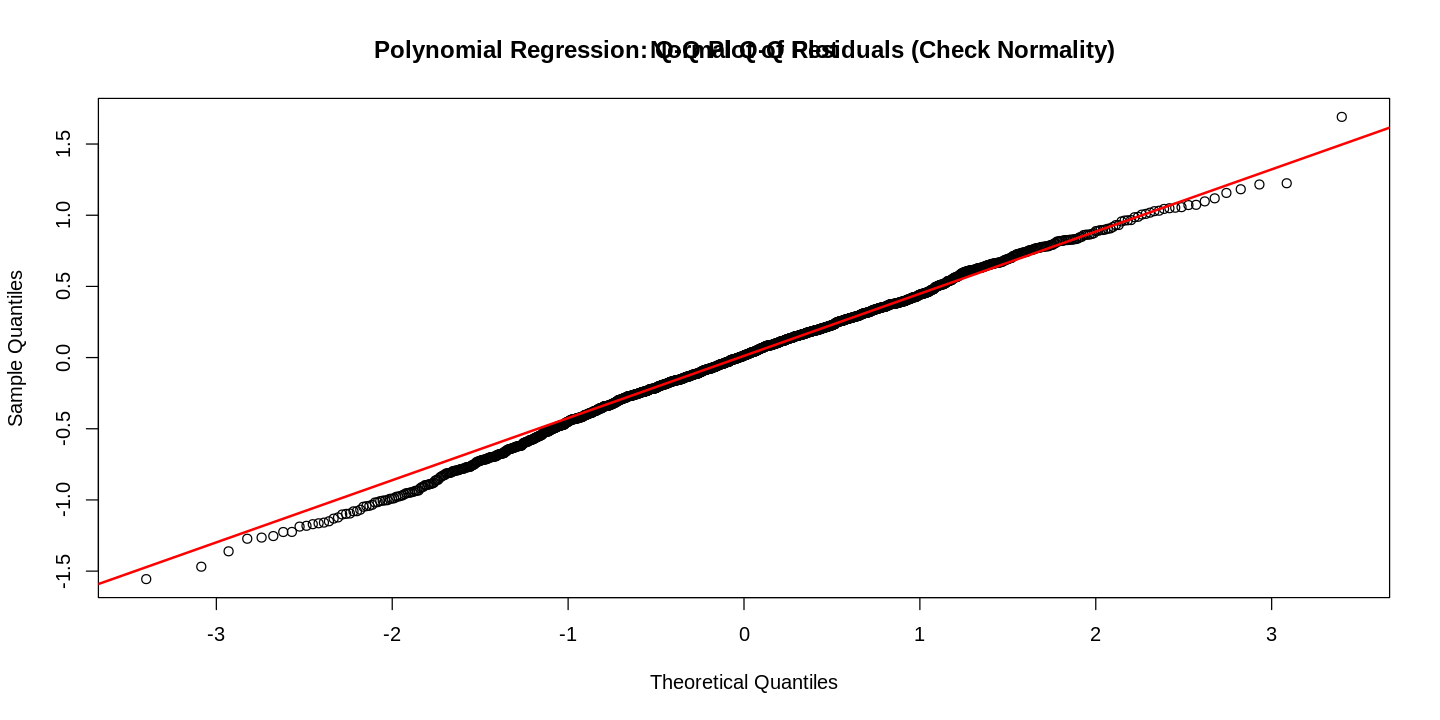

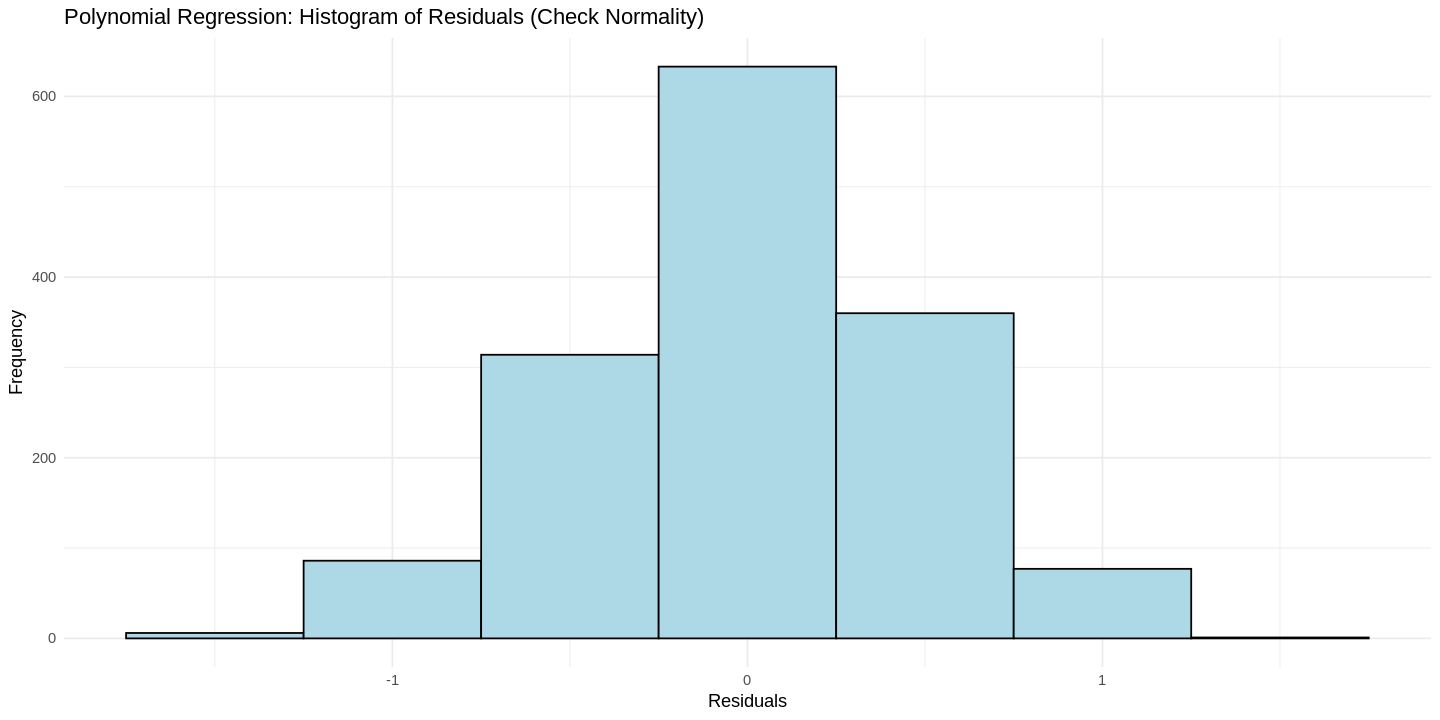

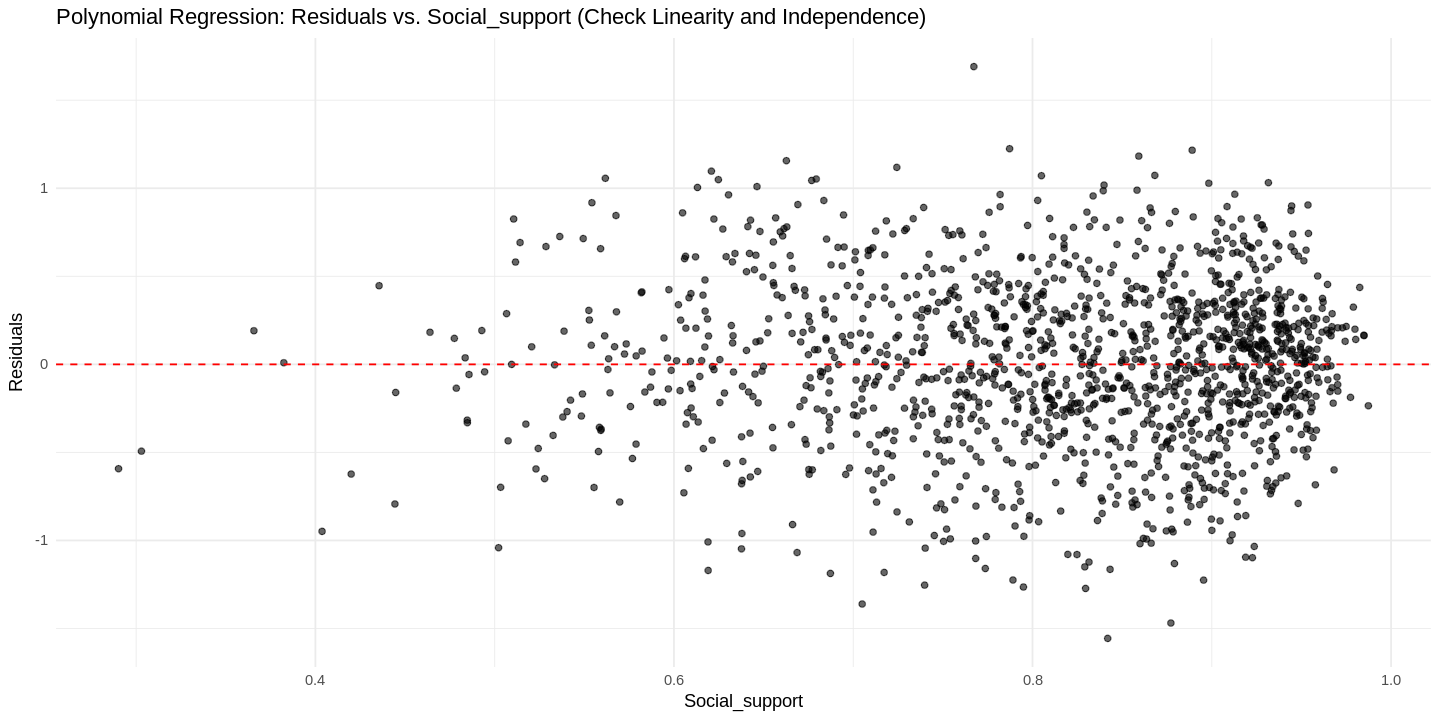

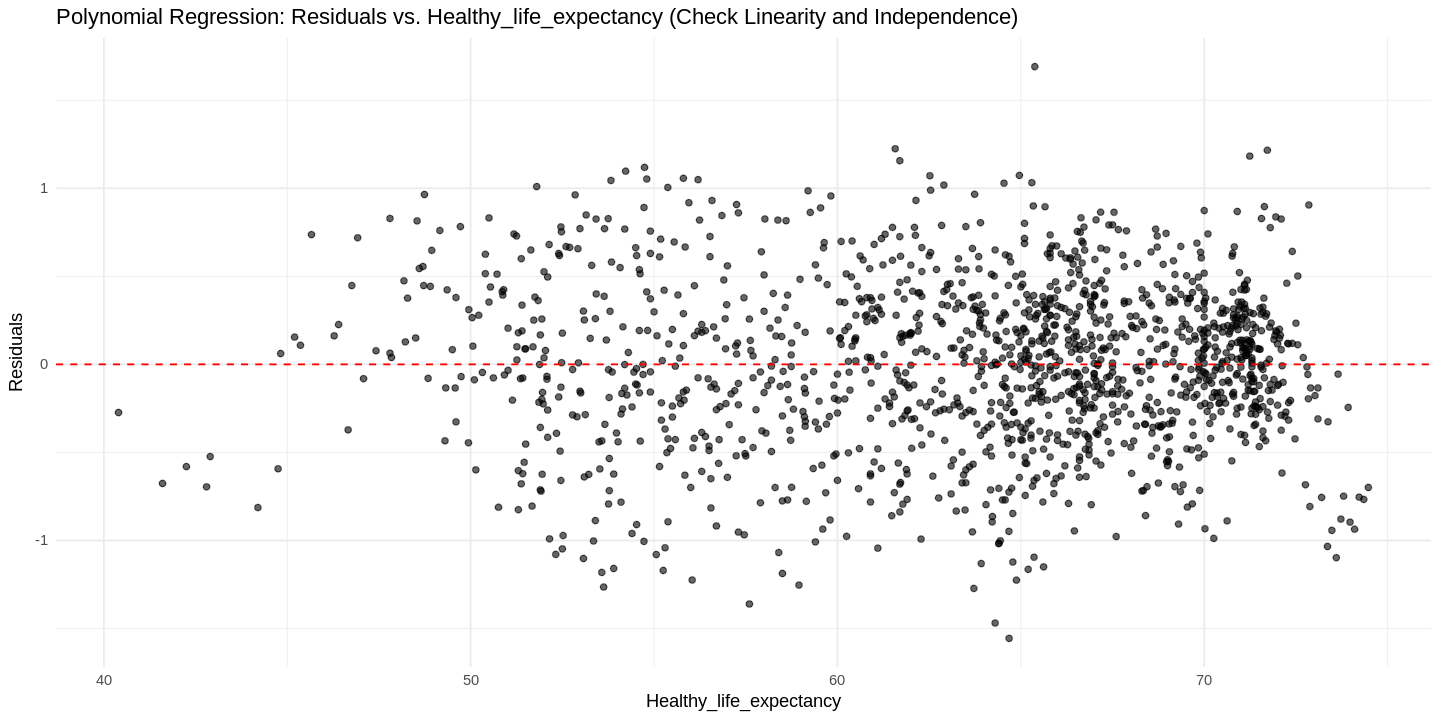

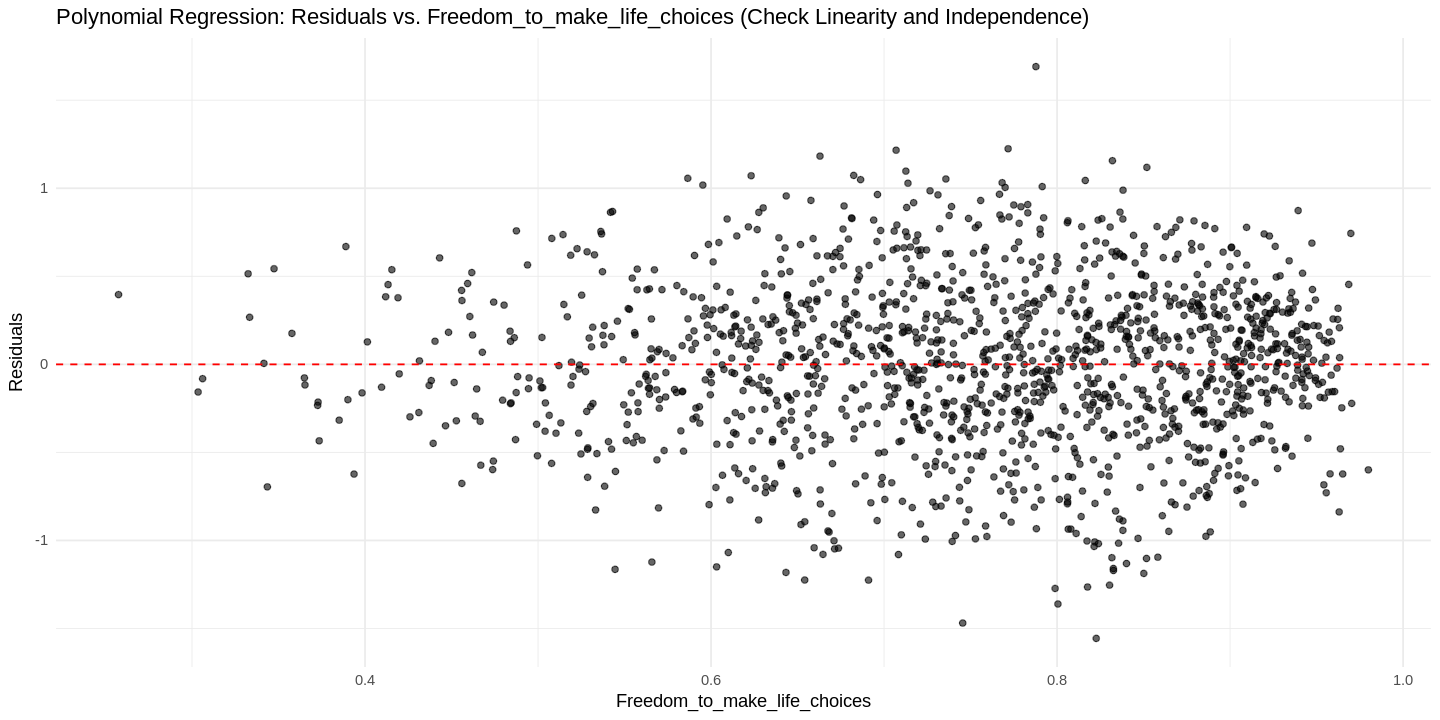

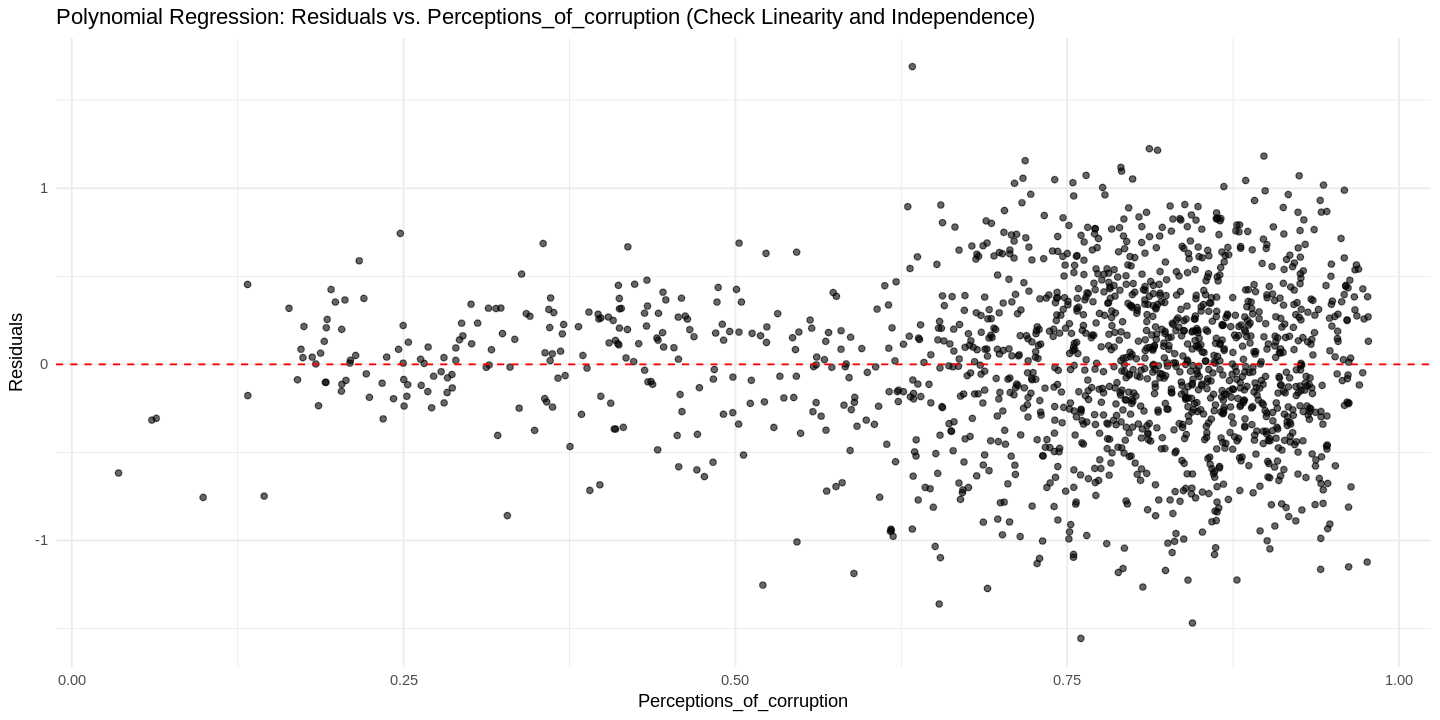

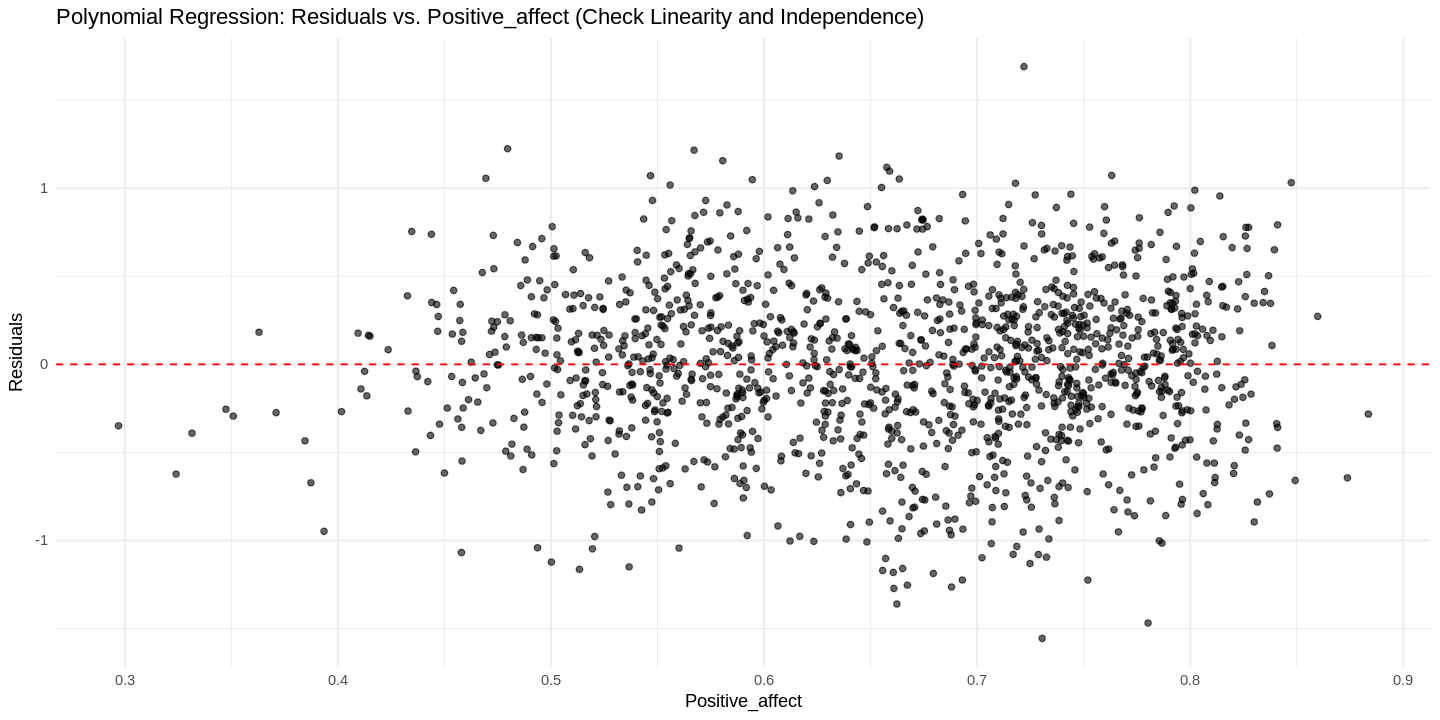

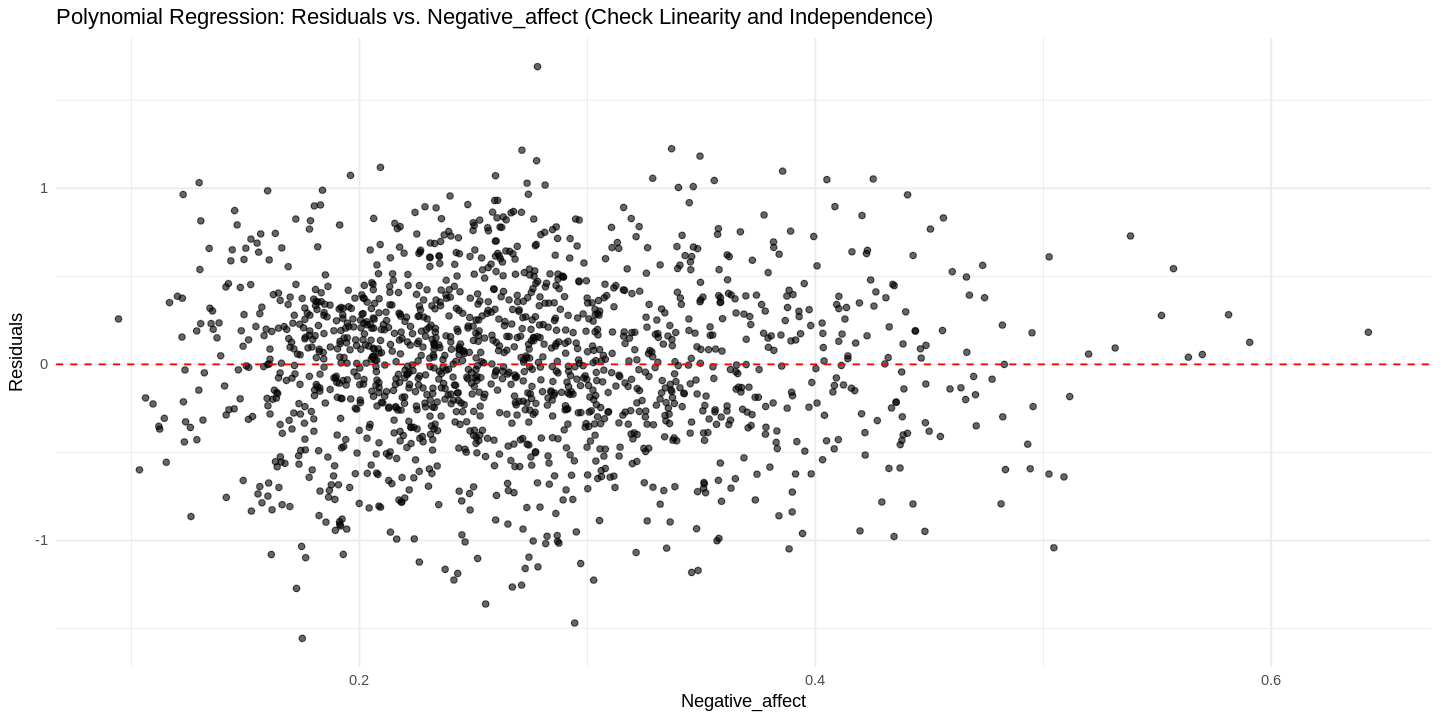

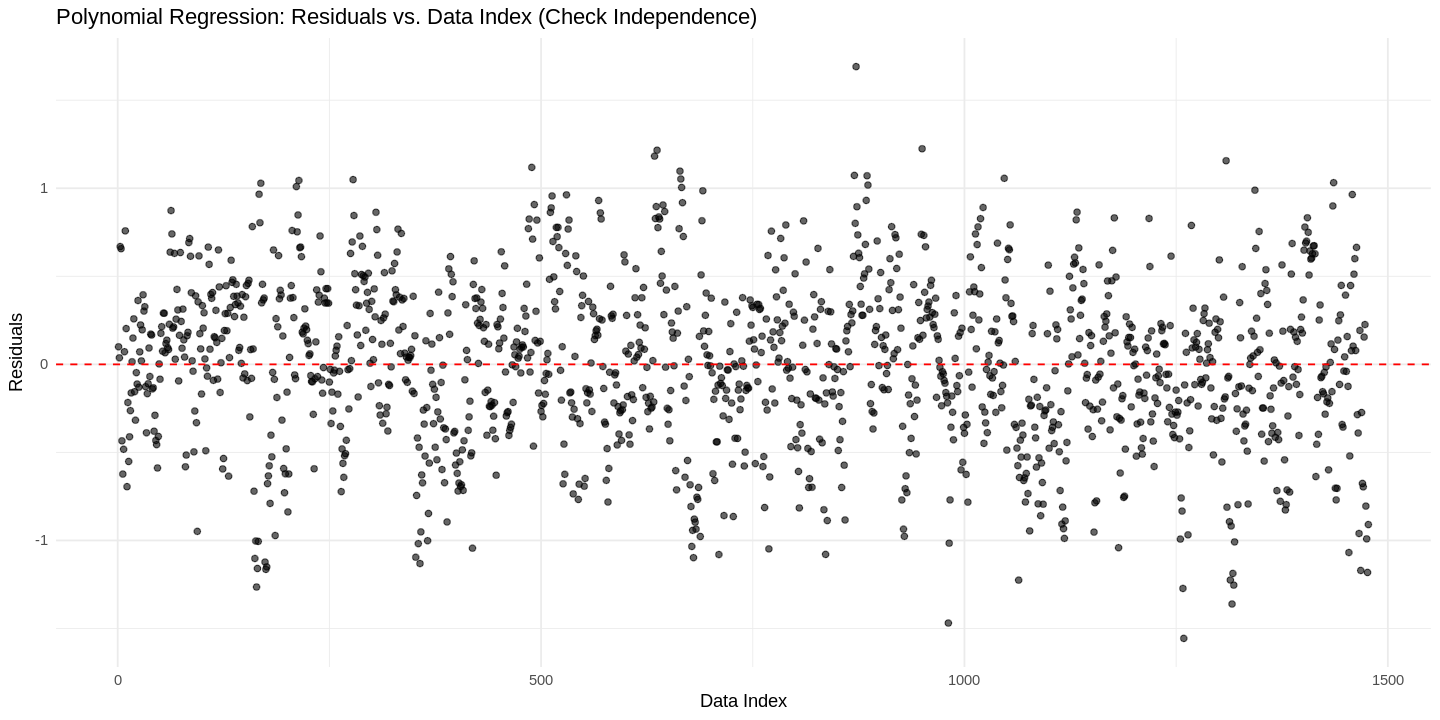

In [34]:
############### Polynomial Regression Residual Analysis ###############

# 1. Calculate Residuals and Fitted Values
residuals_poly <- residuals(poly_model)
fitted_values_poly <- fitted(poly_model)

# 2. Check Zero Mean of Residuals
mean_residuals_poly <- mean(residuals_poly)
cat("Mean of residuals (Polynomial Regression):", mean_residuals_poly, "\n")  # Should be close to zero

# 3. Residuals vs. Fitted Values Plot (Check Homoscedasticity)
# This plot helps check for constant variance of residuals
ggplot(data = data.frame(Fitted = fitted_values_poly, Residuals = residuals_poly),
       aes(x = Fitted, y = Residuals)) +
  geom_point(alpha = 0.6) +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
  labs(title = "Polynomial Regression: Residuals vs. Fitted Values (Check Homoscedasticity)",
       x = "Fitted Values", y = "Residuals") +
  theme_minimal()

# 4. Q-Q Plot of Residuals (Check Normality)
# This plot checks if residuals follow a normal distribution
qqnorm(residuals_poly)
qqline(residuals_poly, col = "red", lwd = 2)
title("Polynomial Regression: Q-Q Plot of Residuals (Check Normality)")

# 5. Histogram of Residuals (Additional Check for Normality)
# This plot helps visually inspect the distribution of residuals
ggplot(data = data.frame(Residuals = residuals_poly), aes(x = Residuals)) +
  geom_histogram(binwidth = 0.5, fill = "lightblue", color = "black") +
  labs(title = "Polynomial Regression: Histogram of Residuals (Check Normality)",
       x = "Residuals", y = "Frequency") +
  theme_minimal()

# 6. Residuals vs. Each Predictor (Check for Independence and Linearity)
# This checks if there are any patterns in residuals against individual predictors
predictors <- c("Social_support", "Healthy_life_expectancy", "Freedom_to_make_life_choices",
                "Perceptions_of_corruption", "Positive_affect", "Negative_affect")

# Loop through each predictor and plot residuals
for (predictor in predictors) {
  plot <- ggplot(data = data.frame(Predictor = happiness_data_train_cleaned[[predictor]], Residuals = residuals_poly),
                 aes(x = Predictor, y = Residuals)) +
    geom_point(alpha = 0.6) +
    geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
    labs(title = paste("Polynomial Regression: Residuals vs.", predictor, "(Check Linearity and Independence)"),
         x = predictor, y = "Residuals") +
    theme_minimal()
  print(plot)  # Print each plot
}

# 7. Residuals vs. Data Index (Check for Independence)
# This plot checks for patterns that may indicate lack of independence
data_index <- seq_along(residuals_poly)
ggplot(data = data.frame(Index = data_index, Residuals = residuals_poly), aes(x = Index, y = Residuals)) +
  geom_point(alpha = 0.6) +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
  labs(title = "Polynomial Regression: Residuals vs. Data Index (Check Independence)",
       x = "Data Index", y = "Residuals") +
  theme_minimal()

              Reference
Predicted      very_unhappy unhappy happy very_happy
  very_unhappy           49      21     1          0
  unhappy                33      70    11          1
  happy                   5      28    77         26
  very_happy              0       0    15         53


Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases




Comparative Results (Accuracy):
                            Model  Accuracy
1 Multinomial Logistic Regression 0.6487179
2                     Naive Bayes 0.6384615

Class-wise Precision Comparison:
                            Model        Class Precision
1 Multinomial Logistic Regression very_unhappy 0.6962025
2 Multinomial Logistic Regression      unhappy 0.6228070
3 Multinomial Logistic Regression        happy 0.5760000
4 Multinomial Logistic Regression   very_happy 0.7638889
5                     Naive Bayes very_unhappy 0.6901408
6                     Naive Bayes      unhappy 0.6086957
7                     Naive Bayes        happy 0.5661765
8                     Naive Bayes   very_happy 0.7794118

Class-wise Recall Comparison:
                            Model        Class    Recall
1 Multinomial Logistic Regression very_unhappy 0.6321839
2 Multinomial Logistic Regression      unhappy 0.5966387
3 Multinomial Logistic Regression        happy 0.6923077
4 Multinomial Logistic Regres

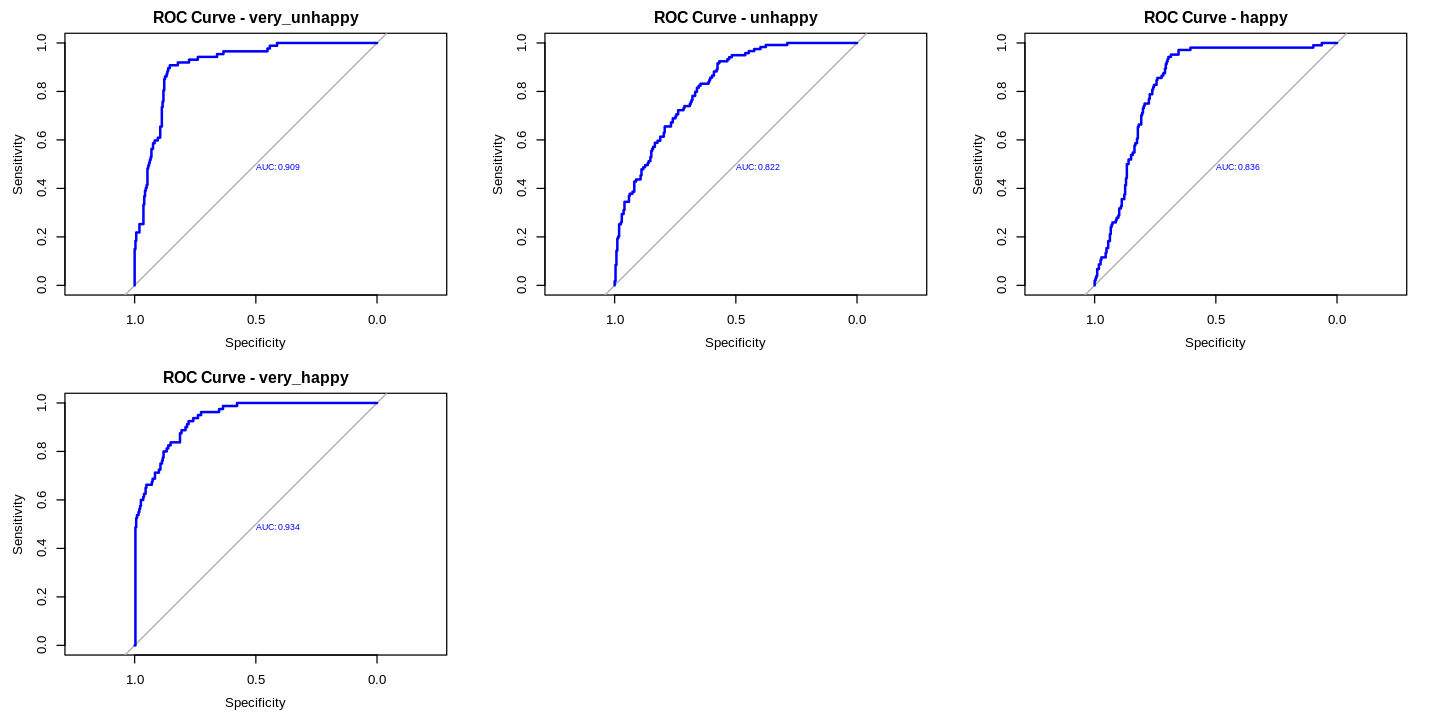

In [35]:
################## Multinomial Logistic Regression vs. Naive Bayes ###############

# Train Naive Bayes Classifier
model_naive_bayes <- naiveBayes(Happiness_Level ~ Social_support + Healthy_life_expectancy +
                                  Freedom_to_make_life_choices + Perceptions_of_corruption +
                                  Positive_affect + Negative_affect,
                                data = happiness_data_train_cleaned)

# Predict classes for the test set
predictions_naive_bayes <- predict(model_naive_bayes, newdata = happiness_data_test)

# Create confusion matrix for Naive Bayes
confusionMatrix_naive_bayes <- table(Predicted = predictions_naive_bayes, Reference = happiness_data_test$Happiness_Level)
print(confusionMatrix_naive_bayes)

# Calculate accuracy for Naive Bayes
accuracy_naive_bayes <- mean(predictions_naive_bayes == happiness_data_test$Happiness_Level)

# Calculate Precision, Recall, and F1-Score for each class
precision_naive_bayes <- diag(confusionMatrix_naive_bayes) / rowSums(confusionMatrix_naive_bayes)
recall_naive_bayes <- diag(confusionMatrix_naive_bayes) / colSums(confusionMatrix_naive_bayes)
f1_score_naive_bayes <- 2 * precision_naive_bayes * recall_naive_bayes / (precision_naive_bayes + recall_naive_bayes)


# Convert Happiness_Level to numeric for ROC analysis
happiness_data_test$Happiness_Level_numeric <- as.numeric(happiness_data_test$Happiness_Level)

# Predict probabilities for Naive Bayes
probabilities_naive_bayes <- predict(model_naive_bayes, newdata = happiness_data_test, type = "raw")

# Initialize a list to store ROC curves
roc_curves_naive_bayes <- list()

# Plot ROC curves for each class
par(mfrow = c(2, 3)) # Set up the plotting area to have 2 rows and 3 columns
for (i in 1:nlevels(happiness_data_test$Happiness_Level)) {
  # Generate ROC curve for the current class
  roc_curves_naive_bayes[[i]] <- roc(happiness_data_test$Happiness_Level_numeric == i, probabilities_naive_bayes[, i])

  # Plot the ROC curve
  plot(roc_curves_naive_bayes[[i]], main = paste("ROC Curve -", levels(happiness_data_test$Happiness_Level)[i]),
       print.auc = TRUE, col = "blue", lwd = 2)
}



############### Comparative Results Display ###############

# Create a summary table for accuracy
results_comparison <- data.frame(
  Model = c("Multinomial Logistic Regression", "Naive Bayes"),
  Accuracy = c(accuracy_multinomial, accuracy_naive_bayes)
)

# Print the summary table
cat("\nComparative Results (Accuracy):\n")
print(results_comparison)

# Combine Precision, Recall, and F1-Score for each model and class
precision_comparison <- data.frame(
  Model = c(rep("Multinomial Logistic Regression", length(precision_multinomial)),
            rep("Naive Bayes", length(precision_naive_bayes))),
  Class = rep(levels(happiness_data_test$Happiness_Level), 2),
  Precision = c(precision_multinomial, precision_naive_bayes)
)

recall_comparison <- data.frame(
  Model = c(rep("Multinomial Logistic Regression", length(recall_multinomial)),
            rep("Naive Bayes", length(recall_naive_bayes))),
  Class = rep(levels(happiness_data_test$Happiness_Level), 2),
  Recall = c(recall_multinomial, recall_naive_bayes)
)

f1_score_comparison <- data.frame(
  Model = c(rep("Multinomial Logistic Regression", length(f1_score_multinomial)),
            rep("Naive Bayes", length(f1_score_naive_bayes))),
  Class = rep(levels(happiness_data_test$Happiness_Level), 2),
  F1_Score = c(f1_score_multinomial, f1_score_naive_bayes)
)

# Print class-wise comparisons
cat("\nClass-wise Precision Comparison:\n")
print(precision_comparison)

cat("\nClass-wise Recall Comparison:\n")
print(recall_comparison)

cat("\nClass-wise F1-Score Comparison:\n")
print(f1_score_comparison)

**####### Step 6: Example Input and Output ##########**

In [36]:
############### Example Input and Output: Multiple Linear Regression ###############

# Example Input (using the first row from the test set as an example)
example_input <- happiness_data_test[1, c("Social_support", "Healthy_life_expectancy",
                                          "Freedom_to_make_life_choices", "Perceptions_of_corruption",
                                          "Positive_affect", "Negative_affect")]

# Convert to a data frame for prediction
example_input_df <- data.frame(example_input)

# Predict the output (Life Ladder) using the Multiple Linear Regression model
example_prediction <- predict(model_multiple_linear, newdata = example_input_df)

# Display Example Input
cat("Example Input:\n")
print(example_input_df)

# Display Predicted Output
cat("\nPredicted Output (Life Ladder):", example_prediction, "\n")

# Optionally, show the actual output for comparison
actual_output <- happiness_data_test$Life_Ladder[1]
cat("\nActual Output (Life Ladder):", actual_output, "\n")

Example Input:
  Social_support Healthy_life_expectancy Freedom_to_make_life_choices
1      0.4506623                    50.5                    0.7181143
  Perceptions_of_corruption Positive_affect Negative_affect
1                 0.8816863        0.414297       0.2581955

Predicted Output (Life Ladder): 2.711127 

Actual Output (Life Ladder): 3.72359 


In [37]:
############### Example Input and Output: Multinomial Logistic Regression ###############

# Example Input (using the second row from the test set as an example)
example_input <- happiness_data_test[8, c("Social_support", "Healthy_life_expectancy",
                                          "Freedom_to_make_life_choices", "Perceptions_of_corruption",
                                          "Positive_affect", "Negative_affect")]

# Convert to a data frame for prediction
example_input_df <- data.frame(example_input)

# Predict the probabilities for each class using the Multinomial Logistic Regression model
example_probabilities <- predict(model_multinomial, newdata = example_input_df, type = "probs")

# Predict the most likely class
example_predicted_class <- predict(model_multinomial, newdata = example_input_df)

# Display Example Input
cat("Example Input:\n")
print(example_input_df)

# Display Predicted Probabilities
cat("\nPredicted Probabilities for Each Class:\n")
print(round(example_probabilities, 3))

# Display Predicted Class
cat("\nPredicted Class (Happiness Level):", example_predicted_class, "\n")

# Show the actual output for comparison
actual_output <- happiness_data_test$Happiness_Level[1]
cat("\nActual Class (Happiness Level):", actual_output, "\n")


Example Input:
  Social_support Healthy_life_expectancy Freedom_to_make_life_choices
1      0.6393561                      69                    0.7038507
  Perceptions_of_corruption Positive_affect Negative_affect
1                  0.884793       0.5790717       0.3504267

Predicted Probabilities for Each Class:
very_unhappy      unhappy        happy   very_happy 
       0.153        0.774        0.072        0.000 

Predicted Class (Happiness Level): 2 

Actual Class (Happiness Level): 1 


In [38]:
############### Example Input and Output: Ridge Regression ###############

# Example Input (using the third row from the test set as an example)
example_input <- happiness_data_test[3, c("Social_support", "Healthy_life_expectancy",
                                          "Freedom_to_make_life_choices", "Perceptions_of_corruption",
                                          "Positive_affect", "Negative_affect")]

# Convert to a model matrix for Ridge Regression
example_input_matrix <- model.matrix(~ ., data = example_input)[, -1]

# Predict the output (Life Ladder) using the Ridge Regression model
example_prediction <- predict(ridge_model_best, s = best_lambda_ridge, newx = example_input_matrix)

# Display Example Input
cat("Example Input:\n")
print(data.frame(example_input))

# Display Predicted Output
cat("\nPredicted Output (Life Ladder):", example_prediction, "\n")

# Show the actual output for comparison
actual_output <- happiness_data_test$Life_Ladder[1]
cat("\nActual Output (Life Ladder):", actual_output, "\n")

Example Input:
  Social_support Healthy_life_expectancy Freedom_to_make_life_choices
1      0.5211036                    51.4                    0.4959014
  Perceptions_of_corruption Positive_affect Negative_affect
1                 0.7311085       0.4798347       0.2671747

Predicted Output (Life Ladder): 3.255703 

Actual Output (Life Ladder): 3.72359 
